# Import Packages

We'll make use of the following packages:
- `numpy` is a package for scientific computing in python.
- `pandas` A powerful Python library for data manipulation and analysis.
- `seaborn` A data visualization library based on matplotlib.
- `scikit-learn` A comprehensive library for machine learning in Python.
- `kaggle` Using Kaggle API to download data.

In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import kagglehub
import os
import math
import matplotlib.pyplot as plt
from scipy.stats import loguniform

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc, roc_curve, accuracy_score, precision_score, recall_score, f1_score, RocCurveDisplay,ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score

from xgboost import XGBClassifier 

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import shap
import warnings
warnings.filterwarnings("ignore")

# Download data

In [17]:
# Download latest version
path = kagglehub.dataset_download("thedevastator/predicting-credit-card-customer-attrition-with-m")

In [18]:
print(os.listdir(path))

['BankChurners.csv']


Have a quick glance of the data.

In [19]:
df = pd.read_csv(os.path.join(path, 'BankChurners.csv'))
df.head()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
0              39  ...       12691.0                  777          11914.0   
1              44  ...        8256.0                  864           7392.0   
2              36  ...        3418.0                    0           3418.0   
3              34  ...        3313.0                 2517            796.0   
4              21  ...        4716.0                    0           4716.0   

   Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0                 1.335             1144              42                1.625   
1                 1.541             1291              33                3.714   
2                 2.594             1887              20                2.333   
3                 1.405             1171              20                2.333   
4                 2.175              816              28                2.500   

   Avg_Utilization_Ratio  \
0                  0.061   
1                  0.105   
2                  0.000   
3                  0.760   
4                  0.000   

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1  \
0                                           0.000093                                                                                    
1                                           0.000057                                                                                    
2                                           0.000021                                                                                    
3                                           0.000134                                                                                    
4                                           0.000022                                                                                    

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2  
0                                            0.99991                                                                                   
1                                            0.99994                                                                                   
2                                            0.99998                                                                                   
3                                            0.99987                                                                                   
4                                            0.99998                                                                                   

[5 rows x 23 columns]

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

Overall, the dataset has 6 non-numerical columns and 17 numerical columns.

# Functions

## Plot Histogram, box and bar plot

### Numerical features

In [21]:
## bar and box plots for numerical features
def plot_box_and_hist_per_feature(dataframe,
                                  hue_col,
                                  cols_per_row=2,
                                  figsize_per_plot=(6, 5),
                                  bins=30,
                                  rotate_xticks=False):
    """
    For each numerical feature, plots a boxplot (by hue) on top and histogram below.
    
    Parameters:
    - dataframe: pandas DataFrame
    - hue_col: Target/grouping column (e.g. 'Attrition_Flag')
    - cols_per_row: Number of features per row (each has 2 subplots: box + hist)
    - figsize_per_plot: Size per feature block (width, height)
    - bins: Bins for histogram
    - rotate_xticks: Whether to rotate x-tick labels
    """

    columns = dataframe.select_dtypes(include='number').columns.tolist()
    if hue_col in columns:
        columns.remove(hue_col)

    n_features = len(columns)
    n_cols = cols_per_row
    n_rows = math.ceil(n_features / n_cols)

    fig, axes = plt.subplots(nrows=n_rows * 2, ncols=n_cols, figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows * 2))
    axes = axes.reshape((n_rows * 2, n_cols))

    for idx, col in enumerate(columns):
        row_idx = (idx // n_cols) * 2
        col_idx = idx % n_cols

        # Boxplot (top)
        sns.boxplot(data=dataframe, x=hue_col, y=col, ax=axes[row_idx][col_idx])
        axes[row_idx][col_idx].set_title(f'{col} - Boxplot by {hue_col}')
        axes[row_idx][col_idx].set_xlabel('')
        if rotate_xticks:
            axes[row_idx][col_idx].tick_params(axis='x', rotation=45)

        # Histogram (bottom)
        sns.histplot(data=dataframe, x=col, hue=hue_col, kde=True, bins=bins,
                     ax=axes[row_idx + 1][col_idx], stat="density", common_norm=False)
        axes[row_idx + 1][col_idx].set_title(f'{col} - Histogram by {hue_col}')
        axes[row_idx + 1][col_idx].set_ylabel('Density')
        if rotate_xticks:
            axes[row_idx + 1][col_idx].tick_params(axis='x', rotation=45)

    # Hide any unused subplots
    total_axes = n_rows * 2 * n_cols
    for i in range(idx + 1, total_axes // 2):
        axes[(i // n_cols) * 2][i % n_cols].set_visible(False)
        axes[(i // n_cols) * 2 + 1][i % n_cols].set_visible(False)

    plt.tight_layout()
    plt.show()

### Categorical features

In [22]:
## bar and box plots for categorical features
def plot_bar_and_normalized_bars(dataframe, cat_cols, target_col, cols_per_row=2, figsize_per_plot=(6, 5), rotate_xticks=True):
    """
    For each categorical feature, plots a count bar chart on top and normalized stacked bar chart below.

    Parameters:
    - dataframe: pandas DataFrame
    - cat_cols: List of categorical columns
    - target_col: Column to group by (e.g., 'Attrition_Flag')
    - cols_per_row: Number of feature blocks per row (each block has 2 subplots)
    - figsize_per_plot: Tuple (width, height) per feature block
    - rotate_xticks: Rotate x-axis labels
    """
    n_features = len(cat_cols)
    n_cols = cols_per_row
    n_rows = math.ceil(n_features / n_cols)

    fig, axes = plt.subplots(nrows=n_rows * 2, ncols=n_cols,
                             figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows * 2))
    axes = axes.reshape((n_rows * 2, n_cols))

    for idx, col in enumerate(cat_cols):
        row_idx = (idx // n_cols) * 2
        col_idx = idx % n_cols

        # Top plot: Countplot (raw counts)
        sns.countplot(data=dataframe, x=col, hue=target_col,
                    ax=axes[row_idx][col_idx],
                    order=dataframe[col].value_counts().index)

        axes[row_idx][col_idx].set_title(f'{col} - Count by {target_col}')
        axes[row_idx][col_idx].set_xlabel('')
        axes[row_idx][col_idx].set_ylabel('Count')
        if rotate_xticks:
            axes[row_idx][col_idx].tick_params(axis='x', rotation=45)

        # Add count labels to each bar
        for container in axes[row_idx][col_idx].containers:
            for bar in container:
                height = bar.get_height()
                if height > 0:
                    axes[row_idx][col_idx].text(
                        bar.get_x() + bar.get_width() / 2,
                        height + 0.01 * height,
                        f'{int(height)}',
                        ha='center', va='bottom', fontsize=8, color='black'
                    )

        # Bottom plot: Normalized bar chart
        norm_df = pd.crosstab(dataframe[col], dataframe[target_col], normalize='index')
        if 'Attrited Customer' in norm_df.columns:
            sorted_index = norm_df['Attrited Customer'].sort_values(ascending=False).index
        else:
            sorted_index = norm_df.iloc[:, 0].sort_values(ascending=False).index

        norm_df = norm_df.loc[sorted_index]
        norm_df.plot(kind='bar', stacked=True, colormap='tab10', ax=axes[row_idx + 1][col_idx])
        axes[row_idx + 1][col_idx].set_title(f'{col} - Normalized % by {target_col}')
        axes[row_idx + 1][col_idx].set_ylabel('Proportion')
        axes[row_idx + 1][col_idx].set_xlabel(col)
        axes[row_idx + 1][col_idx].legend(title=target_col)

        if rotate_xticks:
            axes[row_idx + 1][col_idx].tick_params(axis='x', rotation=45)

        # Add % labels
        for idx2, category in enumerate(norm_df.index):
            bottom = 0
            for cls in norm_df.columns:
                height = norm_df.loc[category, cls]
                axes[row_idx + 1][col_idx].text(idx2, bottom + height / 2,
                                                f'{height*100:.1f}%', ha='center', va='center',
                                                fontsize=9, color='white')
                bottom += height

    # Hide any unused plots
    total_axes = n_rows * 2 * n_cols
    for i in range(idx + 1, total_axes // 2):
        axes[(i // n_cols) * 2][i % n_cols].set_visible(False)
        axes[(i // n_cols) * 2 + 1][i % n_cols].set_visible(False)

    plt.tight_layout()
    plt.show()

## Plot coefficient

In [23]:
def plot_top_logreg_coefficients(coef_df, top_n=20):
    """
    Plots a horizontal bar chart of the top N logistic regression coefficients.
    
    Parameters:
        coef_df (pd.DataFrame): DataFrame with 'Feature' and 'Coefficient' columns.
        top_n (int): Number of top features to plot.
    """
    if "Feature" not in coef_df.columns or "Coefficient" not in coef_df.columns:
        raise ValueError("coef_df must contain 'Feature' and 'Coefficient' columns.")
    
    # Add absolute value for sorting
    coef_df = coef_df.copy()
    coef_df["AbsCoefficient"] = coef_df["Coefficient"].abs()
    top_features = coef_df.sort_values("AbsCoefficient", ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(top_features["Feature"], top_features["Coefficient"],
                    color=["green" if c > 0 else "red" for c in top_features["Coefficient"]])
    plt.xlabel("Coefficient Value")
    plt.title(f"Top {top_n} Logistic Regression Coefficients")
    plt.gca().invert_yaxis()  # Put highest values on top
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

## Plot Correlation Heat Map

In [24]:
def plot_corr_heat_map(dataframe, figsize=(12, 10), annot=True, rotation=45):
    data_numerical = dataframe.select_dtypes(include='number')  # Only keep numerical features

    # Compute correlation matrix
    corr_matrix = data_numerical.corr()

    # Plot heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        corr_matrix, 
        annot=annot, 
        fmt=".2f", 
        cmap='coolwarm', 
        square=True, 
        linewidths=0.5, 
        cbar=True
    )
    plt.title("Correlation Matrix of Numerical Features")

    # Rotate x and y labels
    plt.xticks(rotation=rotation, ha='right')
    
    print("\n📊 Plotting Correlation Matrix of Numerical Features...")

    plt.tight_layout()
    plt.show()

## Plot Feature Importance

In [25]:
def plot_feature_importance(coef, all_feature_names, top_n=20):
    """
    Builds and plots top logistic regression coefficients.

    Parameters:
        coef (array-like): Coefficients from the trained model.
        feature_names (list or array-like): Feature names aligned with the coefficients.
        top_n (int): Number of top features to plot (default = 20).
    """
    # Build DataFrame
    coef_df = pd.DataFrame({
        "Feature": all_feature_names,
        "Coefficient": coef
    }).sort_values(by="Coefficient", key=abs, ascending=False).reset_index(drop=True)

    # Display full list if needed
    pd.set_option("display.max_rows", 100)
    print("\n🔍 Top Logistic Regression Coefficients:\n")
    print(coef_df.head(top_n))

    # Plot
    print("\n📊 Plotting top coefficients...")
    plot_top_logreg_coefficients(coef_df, top_n=top_n)

## Plot Confusion Matrix

In [26]:
def plot_confusion_matrix(y_test, y_pred, best_model):
    """
    Plots a confusion matrix.

    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        best_model (fitted estimator): The trained classifier with a `.classes_` attribute 
                                        (used to label axes and determine positive class).
    """
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

    # Plot Confusion Matrix
    print("\n📊 Plotting Confusion Matrix...")

    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Classification Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=best_model.classes_[1])
    rec = recall_score(y_test, y_pred, pos_label=best_model.classes_[1])
    f1 = f1_score(y_test, y_pred, pos_label=best_model.classes_[1])

    # Print Scores
    print(f"✅ Accuracy:  {acc:.3f}")
    print(f"✅ Precision: {prec:.3f}")
    print(f"✅ Recall:    {rec:.3f}")
    print(f"✅ F1 Score:  {f1:.3f}")

## Plot ROC Curve

In [27]:
def plot_roc_curve(y_test, y_proba, best_model):
    """
    Plots the ROC curve and computes AUC.

    Parameters:
        y_test (array-like): True binary labels.
        y_proba (array-like): Target scores, can either be probability estimates of the positive class or confidence values.
        best_model (fitted estimator): The trained classifier with a `.classes_` attribute 
                                        (used to label axes and determine positive class).
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=best_model.classes_[1])
    roc_auc = auc(fpr, tpr)

    # SPlot ROC curve
    print("\n📊 Plotting ROC Curve...")
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Plot Precision-Recall Curve

In [28]:
def plot_precision_recall_curve(y_test, y_proba, best_model):
    """
    Plots the Precision-Recall curve and computes Average Precision Score.

    Parameters:
        y_test (array-like): True binary labels.
        y_proba (array-like): Target scores, can either be probability estimates of the positive class or confidence values.
        best_model (fitted estimator): The trained classifier with a `.classes_` attribute 
                                        (used to label axes and determine positive class).
    """
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba, pos_label=best_model.classes_[1])
    avg_precision = average_precision_score(y_test, y_proba, pos_label=best_model.classes_[1])

    # Plot
    print("\n📊 Plotting Precision-Recall Curve...")
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, lw=2, color="green", label=f"PR curve (AP = {avg_precision:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Scatter Plot

In [ ]:
def scatter_plot(
    X_test,
    y_test,
    x_col="Total_Trans_Ct_log",
    y_col="Total_Trans_Amt_log",
    positive_label="Attrited Customer",
    negative_label="Existing Customer",
    alpha=0.6,
    figsize=(8, 6)
):
    """
    Scatter plot of two features from X_test, colored by y_test (churn status).

    Parameters:
        X_test (pd.DataFrame): Test features (should include x_col and y_col).
        y_test (pd.Series or np.ndarray): Test labels, indexed to X_test.
        x_col (str): Feature for x-axis.
        y_col (str): Feature for y-axis.
        positive_label (str): Label for positive/churned class.
        negative_label (str): Label for negative/existing class.
        alpha (float): Point transparency.
        figsize (tuple): Figure size.
    """
    # Merge X_test and y_test into one DataFrame for plotting
    plot_df = X_test.copy()
    plot_df["_churn"] = y_test.values

    # Handle binary or string target (0/1 or text)
    unique_vals = plot_df["_churn"].unique()
    if set(unique_vals) == {0, 1}:
        label_map = {0: negative_label, 1: positive_label}
    else:
        # Assume existing text labels; flip if needed
        labels = plot_df["_churn"].unique()
        if positive_label in labels and negative_label in labels:
            label_map = {negative_label: negative_label, positive_label: positive_label}
        else:
            # Fallback: use sorted unique values
            label_map = {labels[0]: negative_label, labels[1]: positive_label}

    plt.figure(figsize=figsize)
    colors = ["#1f77b4", "#d62728"]  # Blue, red

    for churn_val, color in zip(label_map.keys(), colors):
        subset = plot_df[plot_df["_churn"] == churn_val]
        plt.scatter(
            subset[x_col],
            subset[y_col],
            alpha=alpha,
            label=label_map[churn_val],
            color=color,
            edgecolor="w",
            linewidths=0.5
        )

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"{y_col} vs. {x_col} by Churn Status")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
# scatter_plot(X_test, y_test, x_col="Total_Trans_Ct_log", y_col="Total_Trans_Amt_log")

## Plot tree ensemble shap

In [95]:
def plot_tree_ensemble_shap(
    best_model,
    X_test,
    all_feature_names,
    model_step="xgb",
    show=True,
    max_display=20
):
    """
    Generates a SHAP summary plot for any tree ensemble model inside a pipeline.

    Parameters:
        best_model (Pipeline): Trained pipeline object.
        X_test (pd.DataFrame or np.ndarray): Test data (unprocessed).
        all_feature_names (list or np.ndarray): Feature names after transformation.
        model_step (str): Name of the model step in the pipeline ('xgb', 'rf', etc.).
        show (bool): Whether to display the plot immediately.
        max_display (int): Number of top features to display.

    Returns:
        explainer: SHAP TreeExplainer object.
        shap_values: Computed SHAP values.
    """

    # Extract the preprocessor and the fitted model from the pipeline
    preprocessor = best_model.named_steps["pre"]
    model = best_model.named_steps[model_step]

    # Transform the test data
    X_test_trans = preprocessor.transform(X_test)

    # Create SHAP explainer and get SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_trans)

    # Plot SHAP summary (global importance)
    shap.summary_plot(
        shap_values,
        X_test_trans,
        feature_names=all_feature_names,
        show=show,
        max_display=max_display
    )

    return explainer, shap_values

# Example usage:
# plot_tree_ensemble_shap(best_model_xgb_smote_log, X_test_xgb_smote_log, all_feature_names, model_step="xgb")
# plot_tree_ensemble_shap(best_model_rf, X_test_rf, all_feature_names, model_step="rf")

## Random Forest Pipline

### Without SMOTE

In [52]:
def train_rf_pipeline(
    data,
    target_col='Attrition_Flag',
    test_size=0.2,
    random_state=42,
    n_iter=20,
    n_splits=10
):
    # Split features and target
    X = data.drop(columns=[target_col])
    y = data[target_col].map({'Existing Customer': 0, 'Attrited Customer': 1})

    # Split the damn data
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state)

    # Identify column types
    cat_cols = X.select_dtypes(include="object").columns.tolist()
    num_cols = X.select_dtypes(include="number").columns.tolist()

    # Preprocessing: skip StandardScaler for RF, keep OneHot
    preprocessor = ColumnTransformer([
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ])

    # Pipeline: RandomForestClassifier
    pipe = Pipeline([
        ("pre", preprocessor),
        ("rf", RandomForestClassifier(random_state=random_state))
    ])

    # Hyperparameter grid for RandomForest
    param_dist = {
        'rf__n_estimators': np.arange(50, 301, 50),
        'rf__max_depth': [None, 5, 10, 20, 30],
        'rf__min_samples_split': [2, 5, 10],
        'rf__min_samples_leaf': [1, 2, 4],
        'rf__max_features': [None, 'sqrt', 'log2'],
        'rf__bootstrap': [True, False]
    }

    # Cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Randomized Search
    search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                n_iter=n_iter, scoring="roc_auc", cv=cv,
                                n_jobs=-1, random_state=random_state, verbose=2)

    # Fit data to model
    search.fit(X_trainval, y_trainval)

    # Results
    print("Best parameters:", search.best_params_)
    print("Best CV ROC AUC:", search.best_score_)

    # Final test evaluation
    y_pred = search.predict(X_test)
    y_proba = search.predict_proba(X_test)[:, 1]

    print("\nTest ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return search, X_test, y_test, y_pred, y_proba, cat_cols, num_cols

### With SMOTE

In [50]:
def train_rf_pipeline_with_smote(
    data,
    target_col='Attrition_Flag',
    test_size=0.2,
    random_state=42,
    n_iter=20,
    n_splits=10
):
    # Split features and target
    X = data.drop(columns=[target_col])
    y = data[target_col].map({'Existing Customer': 0, 'Attrited Customer': 1})

    # Split the damn data
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state)

    # Identify column types
    cat_cols = X.select_dtypes(include="object").columns.tolist()
    num_cols = X.select_dtypes(include="number").columns.tolist()

    # Preprocessing: skip StandardScaler for RF, keep OneHot
    preprocessor = ColumnTransformer([
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ])

    # ImbPipeline: Preprocessing -> SMOTE -> RF
    pipe = ImbPipeline([
        ("pre", preprocessor),
        ("smote", SMOTE(random_state=random_state)),
        ("rf", RandomForestClassifier(random_state=random_state))
    ])

    # Hyperparameter grid for RandomForest
    param_dist = {
        'rf__n_estimators': np.arange(50, 301, 50),
        'rf__max_depth': [None, 5, 10, 20, 30],
        'rf__min_samples_split': [2, 5, 10],
        'rf__min_samples_leaf': [1, 2, 4],
        'rf__max_features': [None, 'sqrt', 'log2'],
        'rf__bootstrap': [True, False]
    }

    # Cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Randomized Search
    search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                n_iter=n_iter, scoring="roc_auc", cv=cv,
                                n_jobs=-1, random_state=random_state, verbose=2)

    # Fit data to model
    search.fit(X_trainval, y_trainval)

    # Results
    print("Best parameters:", search.best_params_)
    print("Best CV ROC AUC:", search.best_score_)

    # Final test evaluation
    y_pred = search.predict(X_test)
    y_proba = search.predict_proba(X_test)[:, 1]

    print("\nTest ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return search, X_test, y_test, y_pred, y_proba, cat_cols, num_cols

## XGBoost Pipeline
### Without SMOTE

In [115]:
def train_xgb_pipeline(
    data,
    target_col='Attrition_Flag',
    test_size=0.2,
    random_state=42,
    n_iter=20,
    n_splits=10
):
    # Split features and target
    X = data.drop(columns=[target_col])
    y = data[target_col].map({'Existing Customer': 0, 'Attrited Customer': 1})

    # Split the data
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state)

    # Identify column types
    cat_cols = X.select_dtypes(include="object").columns.tolist()
    num_cols = X.select_dtypes(include="number").columns.tolist()

    # Preprocessing: keep OneHot, skip StandardScaler
    preprocessor = ColumnTransformer([
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ])

    # Pipeline: XGBoost
    pipe = Pipeline([
        ("pre", preprocessor),
        ("xgb", XGBClassifier(
            # tree_method='gpu_hist',      # Enable GPU acceleration 
            # predictor='gpu_predictor',   # but not supported by apple silicon yet
            objective='binary:logistic',
            eval_metric='auc',
            # use_label_encoder=False,
            random_state=random_state,
            n_jobs=-1
        ))
    ])

    # Hyperparameter grid for XGBoost
    param_dist = {
        'xgb__n_estimators': np.arange(50, 301, 50),
        'xgb__max_depth': [3, 5, 7, 10],
        'xgb__learning_rate': np.logspace(-2, 0, 5),  # e.g., 0.01, 0.03, 0.1, 0.3, 1
        'xgb__subsample': [0.6, 0.8, 1.0],
        'xgb__colsample_bytree': [0.6, 0.8, 1.0],
        'xgb__gamma': [0, 1, 5],
        'xgb__reg_alpha': [0, 0.01, 0.1, 1],
        'xgb__reg_lambda': [0.1, 1, 10]
    }

    # Cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Randomized Search
    search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                n_iter=n_iter, scoring="roc_auc", cv=cv,
                                n_jobs=-1, random_state=random_state, verbose=1)

    # Fit data to model
    search.fit(X_trainval, y_trainval)

    # Results
    print("Best parameters:", search.best_params_)
    print("Best CV ROC AUC:", search.best_score_)

    # Final test evaluation
    y_pred = search.predict(X_test)
    y_proba = search.predict_proba(X_test)[:, 1]

    print("\nTest ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return search, X_test, y_test, y_pred, y_proba, cat_cols, num_cols

### With SMOTE

In [122]:
def train_xgb_pipeline_with_smote(
    data,
    target_col='Attrition_Flag',
    test_size=0.2,
    random_state=42,
    n_iter=20,
    n_splits=10
):
    # Split features and target
    X = data.drop(columns=[target_col])
    y = data[target_col].map({'Existing Customer': 0, 'Attrited Customer': 1})

    # Split the damn data
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state)

    # Identify column types
    cat_cols = X.select_dtypes(include="object").columns.tolist()
    num_cols = X.select_dtypes(include="number").columns.tolist()

    # Preprocessing: skip StandardScaler for XGBoost, keep OneHot
    preprocessor = ColumnTransformer([
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ])

    # ImbPipeline: Preprocessing -> SMOTE -> XGBoost
    pipe = ImbPipeline([
        ("pre", preprocessor),
        ("smote", SMOTE(random_state=random_state)),
        ("xgb", XGBClassifier(
            # tree_method='gpu_hist',      # Enable GPU acceleration 
            # predictor='gpu_predictor',   # but not supported by apple silicon yet
            objective='binary:logistic',
            eval_metric='auc',
            # use_label_encoder=False,
            random_state=random_state,
            n_jobs=-1
        ))
    ])

    # Hyperparameter grid for XGBoost
    param_dist = {
        'xgb__n_estimators': np.arange(50, 301, 50),
        'xgb__max_depth': [3, 5, 7, 10],
        'xgb__learning_rate': np.logspace(-2, 0, 5),  # e.g., 0.01, 0.03, 0.1, 0.3, 1
        'xgb__subsample': [0.6, 0.8, 1.0],
        'xgb__colsample_bytree': [0.6, 0.8, 1.0],
        'xgb__gamma': [0, 1, 5],
        'xgb__reg_alpha': [0, 0.01, 0.1, 1],
        'xgb__reg_lambda': [0.1, 1, 10]
    }

    # Cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Randomized Search
    search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                n_iter=n_iter, scoring="roc_auc", cv=cv,
                                n_jobs=-1, random_state=random_state, verbose=1)

    # Fit data to model
    search.fit(X_trainval, y_trainval)

    # Results
    print("Best parameters:", search.best_params_)
    print("Best CV ROC AUC:", search.best_score_)

    # Final test evaluation
    y_pred = search.predict(X_test)
    y_proba = search.predict_proba(X_test)[:, 1]

    print("\nTest ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return search, X_test, y_test, y_pred, y_proba, cat_cols, num_cols

## Get best model 

In [59]:
def get_best_model(search, cat_cols, num_cols, named_step):
    """
    Returns the best model and feature info from the RandomizedSearchCV object.

    Parameters:
        search (RandomizedSearchCV): The fitted RandomizedSearchCV object.
        cat_cols (list): List of categorical feature names.
        num_cols (list): List of numerical feature names.
        named_step (str): Name of the model step in the pipeline ('logreg', 'rf', 'xgb', etc.).

    Returns:
        best_model (Pipeline): The best model pipeline.
        coef_or_importances (np.ndarray): Coefficients or feature importances.
        all_feature_names (np.ndarray): Array of feature names.
    """
    best_model = search.best_estimator_

    # Get transformers
    ohe = best_model.named_steps["pre"].named_transformers_["cat"]

    # Get feature names
    cat_feature_names = ohe.get_feature_names_out(cat_cols)
    num_feature_names = num_cols
    all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

    # Get coefficients or feature importances
    estimator = best_model.named_steps[named_step]
    if hasattr(estimator, 'coef_'):
        coef_or_importances = estimator.coef_.flatten()
    elif hasattr(estimator, 'feature_importances_'):
        coef_or_importances = estimator.feature_importances_
    else:
        raise AttributeError(f"Estimator '{named_step}' has neither coef_ nor feature_importances_.")

    return best_model, coef_or_importances, all_feature_names

## Metrics Visualization

In [34]:
def plot_metrics(y_test, y_pred, y_proba, coef, best_model, all_feature_names, top_n=20):
    """
    Plots ROC curve, Precision-Recall curve, and Confusion Matrix.

    Parameters:
        y_test (array-like): True labels.
        y_proba (array-like): Predicted probabilities.
        best_model (Pipeline): The best model pipeline.
    """
    # Plot feature importance
    plot_feature_importance(coef, all_feature_names, top_n=20)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(y_test, y_pred, best_model)

    # Plot ROC curve
    plot_roc_curve(y_test, y_proba, best_model)

    # Plot Precision-Recall curve
    plot_precision_recall_curve(y_test, y_proba, best_model)


# Data Cleaning

The explanation for each columns.

`CLIENTNUM`: Unique identifier for each customer. (Integer)  
`Attrition_Flag`: Flag indicating whether or not the customer has churned out. (Boolean)  
`Customer_Age`: Age of customer. (Integer)  
`Gender`: Gender of customer. (String)  
`Dependent_count`: Number of dependents that customer has. (Integer)  
`Education_Level`: Education level of customer. (String)  
`Marital_Status`: Marital status of customer. (String)  
`Income_Category`: Income category of customer. (String)  
`Card_Category`: Type of card held by customer. (String)  
`Months_on_book`: How long customer has been on the books. (Integer)  
`Total_Relationship_Count`: Total number of relationships customer has with the credit card provider. (Integer)  
`Months_Inactive_12_mon`: Number of months customer has been inactive in the last twelve months. (Integer)  
`Contacts_Count_12_mon`: Number of contacts customer has had in the last twelve months. (Integer)  
`Credit_Limit`: Credit limit of customer. (Integer)  
`Total_Revolving_Bal`: Total revolving balance of customer. (Integer)  
`Avg_Open_To_Buy`: Average open to buy ratio of customer. (Integer)  
`Total_Amt_Chng_Q4_Q1`: Total amount changed from quarter 4 to quarter 1. (Integer)  
`Total_Trans_Amt`: Total transaction amount. (Integer)  
`Total_Trans_Ct`: Total transaction count. (Integer)  
`Total_Ct_Chng_Q4_Q1`: Total count changed from quarter 4 to quarter 1. (Integer)  
`Avg_Utilization_Ratio`: Average utilization ratio of customer. (Integer)  

By checking the first 5 rows, we can see there are 3 columns are not relevant: `CLIENTNUM`, `Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1`, `Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2`. 

The `Naive_Bayes_Classifier_Attrition_Flag` columns look like a pre-engineered model output (maybe added by mistake). We should probably drop it unless we know exactly how it was generated. Otherwise, it risks leaking information into our model.

Therefore, we will remove these 3 before data cleaning.

## Drop not useful columns

In [35]:
data = df.copy()
data.drop(columns=["CLIENTNUM", 
                   "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1", 
                   "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"]
                   , inplace=True)

## Check if duplicates in dataset

In [36]:
"""
Check row duplicates and drop them if any.
"""
if data.duplicated().any() == False:
    print("NO duplicates found")
else:
    dup_row_cnt = data.duplicated().sum()
    print(f"Duplicates FOUND: {dup_row_cnt}")
    
    # Drop duplicates
    data.drop_duplicates(inplace=True)
    print("Duplicates dropped")

NO duplicates found


## Check missing data

In [37]:
data.isna().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

This dataset contains no missing values across any columns.

However, if there were any, we could apply data imputation techniques to handle the missing values.

# Exploratory Data Analysis (EDA)

## Describe data

In [38]:
data.describe()

Customer_Age  Dependent_count  Months_on_book  \
count  10127.000000     10127.000000    10127.000000   
mean      46.325960         2.346203       35.928409   
std        8.016814         1.298908        7.986416   
min       26.000000         0.000000       13.000000   
25%       41.000000         1.000000       31.000000   
50%       46.000000         2.000000       36.000000   
75%       52.000000         3.000000       40.000000   
max       73.000000         5.000000       56.000000   

       Total_Relationship_Count  Months_Inactive_12_mon  \
count              10127.000000            10127.000000   
mean                   3.812580                2.341167   
std                    1.554408                1.010622   
min                    1.000000                0.000000   
25%                    3.000000                2.000000   
50%                    4.000000                2.000000   
75%                    5.000000                3.000000   
max                    6.000000                6.000000   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
count           10127.000000  10127.000000         10127.000000   
mean                2.455317   8631.953698          1162.814061   
std                 1.106225   9088.776650           814.987335   
min                 0.000000   1438.300000             0.000000   
25%                 2.000000   2555.000000           359.000000   
50%                 2.000000   4549.000000          1276.000000   
75%                 3.000000  11067.500000          1784.000000   
max                 6.000000  34516.000000          2517.000000   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
count     10127.000000          10127.000000     10127.000000    10127.000000   
mean       7469.139637              0.759941      4404.086304       64.858695   
std        9090.685324              0.219207      3397.129254       23.472570   
min           3.000000              0.000000       510.000000       10.000000   
25%        1324.500000              0.631000      2155.500000       45.000000   
50%        3474.000000              0.736000      3899.000000       67.000000   
75%        9859.000000              0.859000      4741.000000       81.000000   
max       34516.000000              3.397000     18484.000000      139.000000   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
count         10127.000000           10127.000000  
mean              0.712222               0.274894  
std               0.238086               0.275691  
min               0.000000               0.000000  
25%               0.582000               0.023000  
50%               0.702000               0.176000  
75%               0.818000               0.503000  
max               3.714000               0.999000

In [39]:
data.describe(include='object')

Attrition_Flag Gender Education_Level Marital_Status  \
count               10127  10127           10127          10127   
unique                  2      2               7              4   
top     Existing Customer      F        Graduate        Married   
freq                 8500   5358            3128           4687   

       Income_Category Card_Category  
count            10127         10127  
unique               6             4  
top     Less than $40K          Blue  
freq              3561          9436

* For numerical features, we can see that the scales differ across features. Therefore, we need to apply **feature scaling** before fitting the data into the *logistic regression* model.
* For non-numerical features, we need to apply **one-hot encoding** to transform the data before fitting it into the model.

## Histogram, Box and Bar Plots

We are using `Attrition_Flag` as the target variable, and it’s noticeable that the data is imbalanced. Therefore, we need to apply **stratified sampling** to ensure that the train/test splits maintain the same proportion of target classes (or other feature categories) as the original dataset.

As for the categorical features, the distribution between female and male customers is relatively balanced. Meanwhile, customers with graduate degrees, those who are married, those with an income under $40K, and Blue card holders represent the majority groups.

### Numerical Features

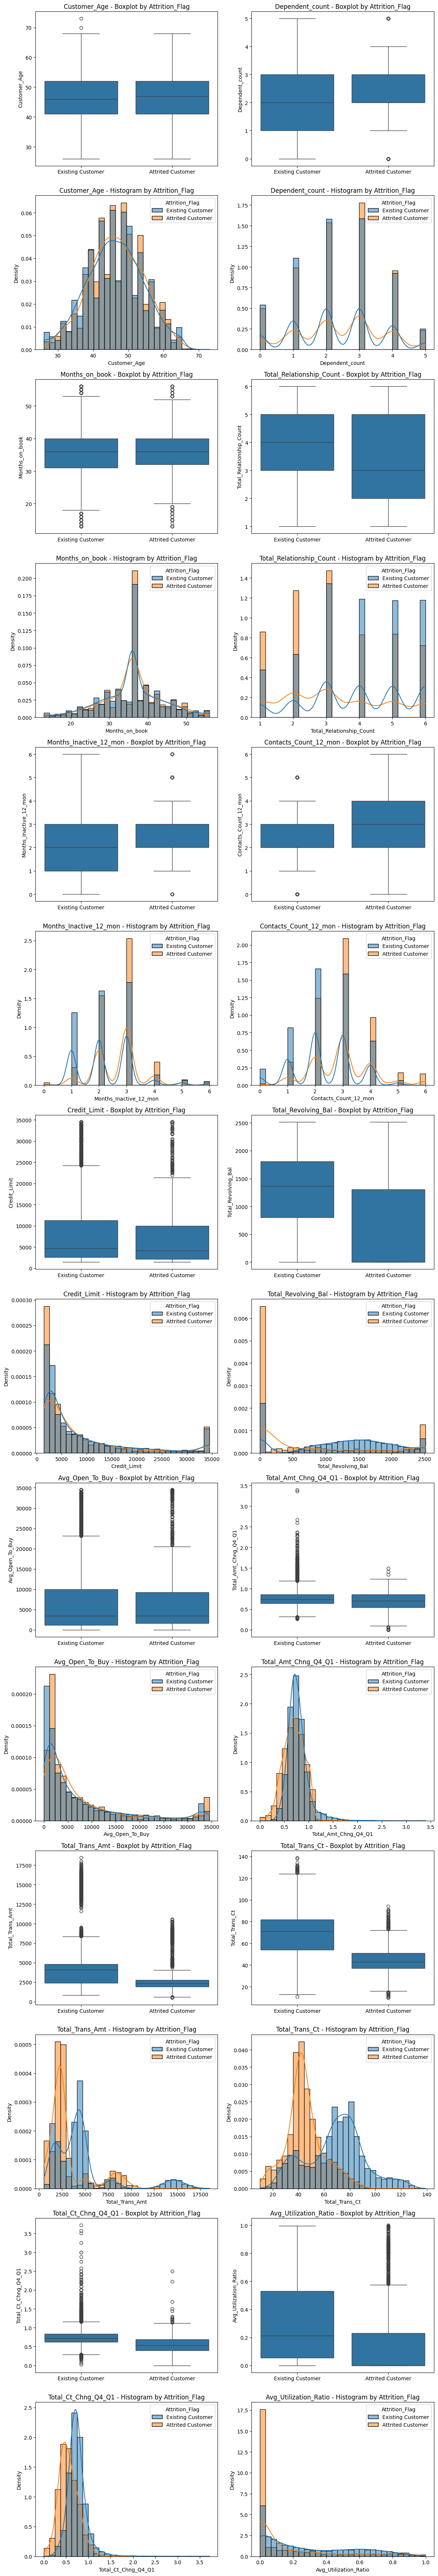

In [40]:
plot_box_and_hist_per_feature(data, hue_col='Attrition_Flag', cols_per_row=2, figsize_per_plot=(6, 5), bins=30, rotate_xticks=False)

#### 📊 Churn Insights by Numerical Feature (Grouped by Predictive Strength)

##### ✅ Strong Predictors

|         Feature             |        Most Churn-Prone Group        | Insight                                                  |
|----------------------------|:------------------------------------:|:----------------------------------------------------------|
| Total_Trans_Ct             | Low transaction count (<60)          | Strong predictor — low activity = high churn              |
| Total_Trans_Amt            | Low transaction amount (<5000)       | Lower spending = disengagement → higher churn             |
| Total_Ct_Chng_Q4_Q1        | Low change in transaction count      | No growth in behavior may signal disengagement            |
| Months_Inactive_12_mon     | Higher inactivity (3–4 months)       | Very strong churn indicator — inactivity is a red flag     |

##### 🟡 Moderate Predictors

|         Feature             |        Most Churn-Prone Group        | Insight                                                  |
|----------------------------|:------------------------------------:|:----------------------------------------------------------|
| Avg_Utilization_Ratio      | Low utilization (≤0.2)               | Underutilization may imply lack of need or interest       |
| Credit_Limit               | Low credit limit (<5000)             | Lower trust or fewer incentives to stay                   |
| Avg_Open_To_Buy            | Low open-to-buy (<5000)              | Mirrors credit limit pattern — less flexibility → churn   |
| Total_Relationship_Count   | Fewer relationships (1–2)            | Customers with fewer products are more likely to leave    |
| Months_on_book             | Longer tenure (>40 months)           | Long-timers might leave due to fatigue or better offers   |

##### ❌ Weak Predictors

|         Feature             |        Most Churn-Prone Group        | Insight                                                  |
|----------------------------|:------------------------------------:|:----------------------------------------------------------|
| Customer_Age               | Slightly older (50+)                 | Weak signal — minor shift toward older customers          |
| Dependent_count            | No clear pattern                     | Weak predictor — distribution nearly identical            |

### Categorical features - Bax and Bar Plots

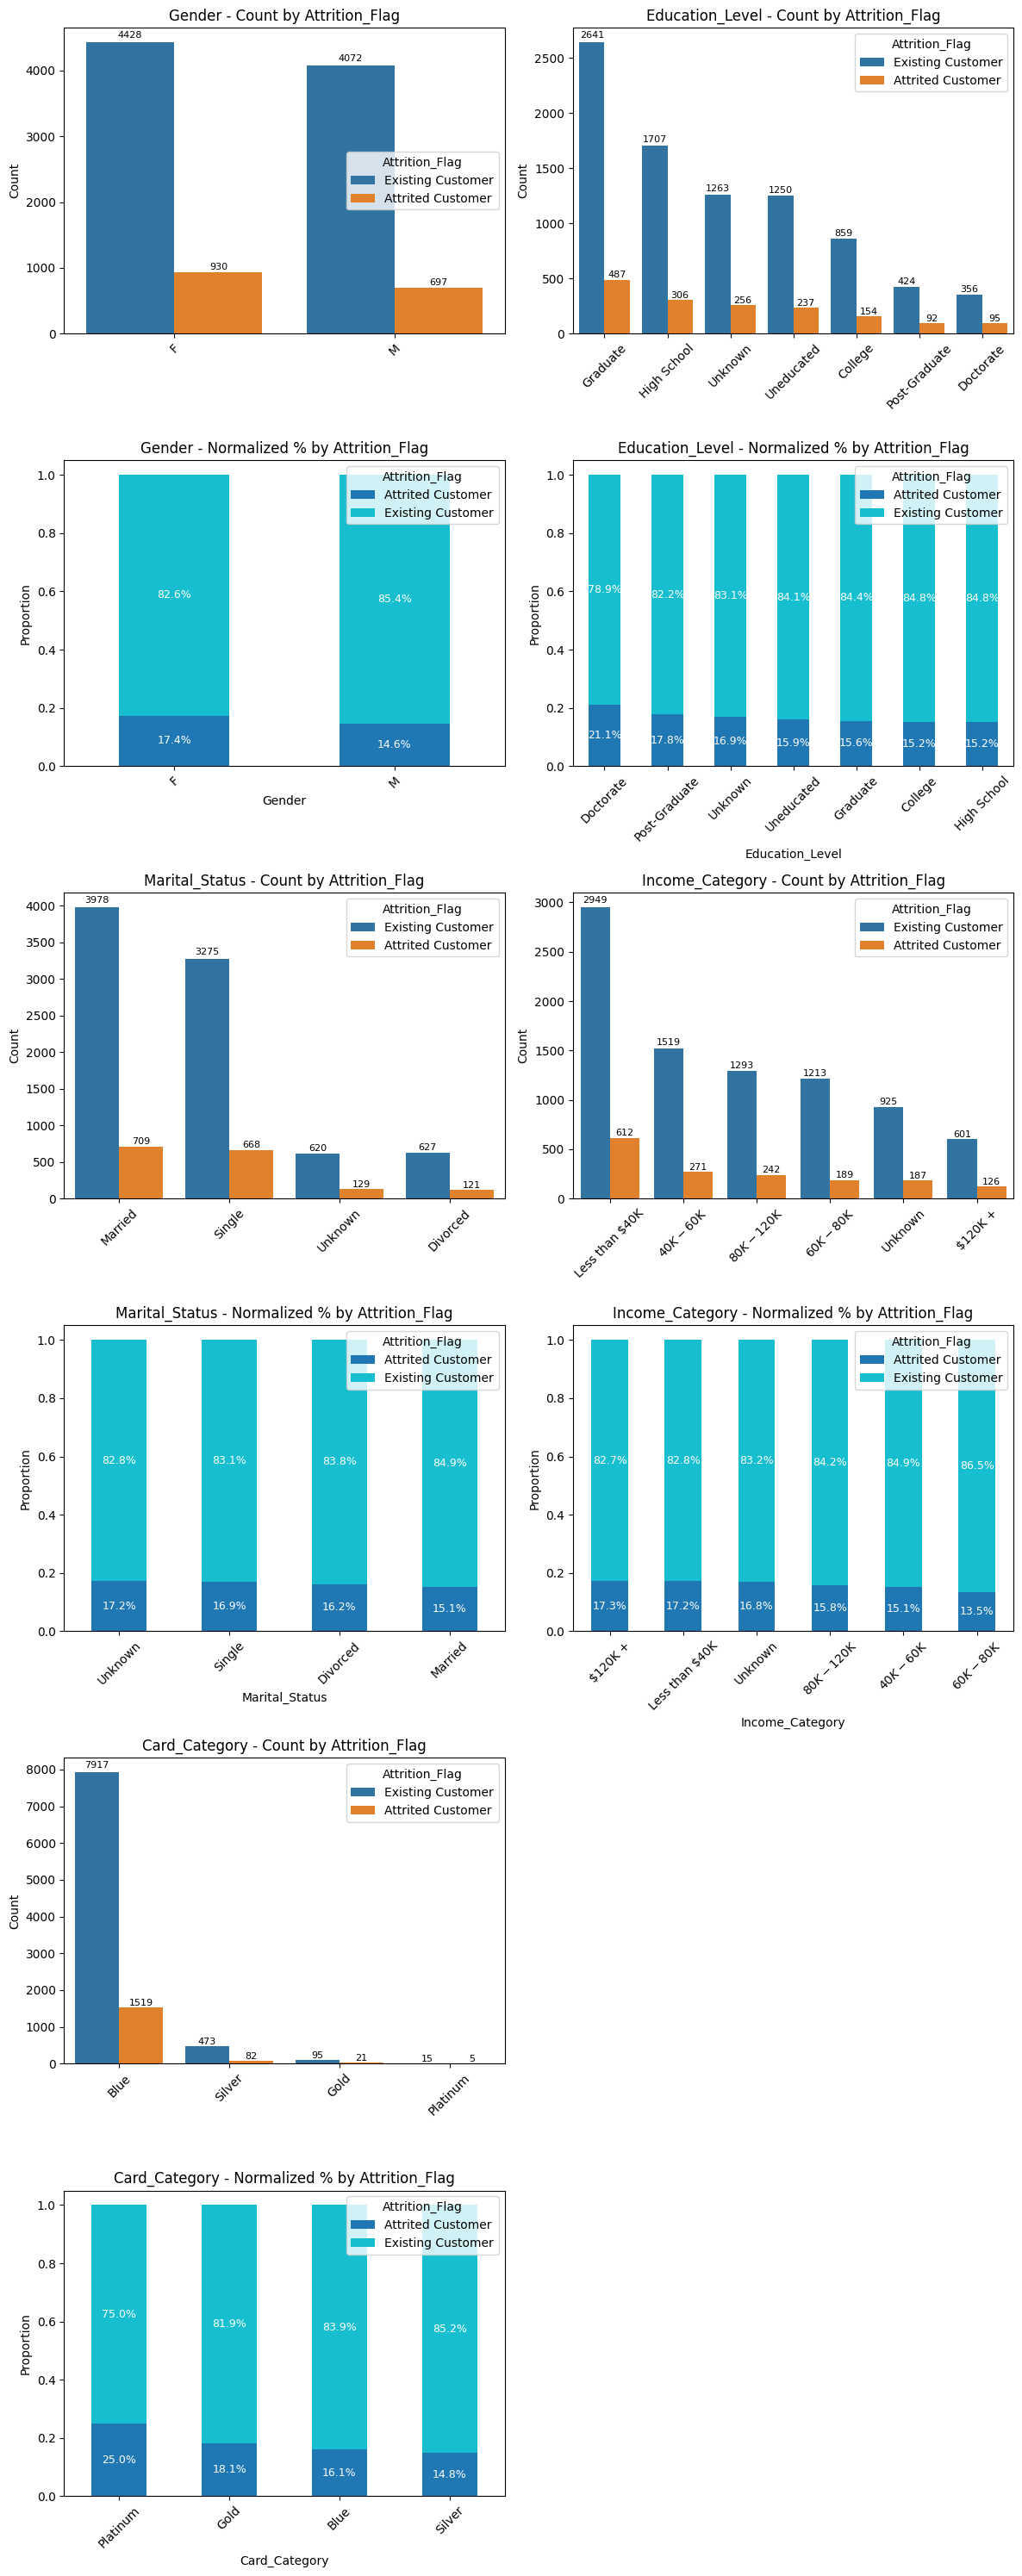

In [41]:
cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
cat_norm_cols = [col for col in cat_cols if col != 'Attrition_Flag']
plot_bar_and_normalized_bars(data, cat_cols = cat_norm_cols, target_col='Attrition_Flag', cols_per_row=2, figsize_per_plot=(6, 5), rotate_xticks=True)

#### 📊 Categorical Churn Insights

| Feature         | Insights                                                              | Reasoning                                                                 |
|-----------------|------------------------------------------------------------------------------------------|---------------------------------------------------------------------------|
| Card Category   | 🔍 Modeling: Use **Platinum** (25% churn rate)<br>📊 Business: Focus on **Blue** (high volume) | Platinum has highest churn %; Blue has most actual churners               |
| Education       | 🔍 Modeling: Flag **Doctorate** (21.1%)<br>📊 Business: Monitor **Graduate** & **High School** | Doctorate churns more; larger volume comes from mid-education groups      |
| Marital Status  | 🔍 Modeling: Watch **Unknown** / **Divorced**<br>📊 Business: Focus on **Single** / **Married** | Unknown has highest churn %, but most churn cases are from larger groups (*Married* and *Single*)  |
| Income Category | 🔍 Modeling: Use **Unknown**, **<40K** and **>$120K** as high risk<br>📊 Business: Retain **$60K–$80K**       | Churn rate is higher at extremes; stable middle-income is large & loyal   |
| Gender          | ❌ Not useful for modeling or targeting                                                  | Very small difference in churn % between Female and Male                  |

## Correlation


📊 Plotting Correlation Matrix of Numerical Features...


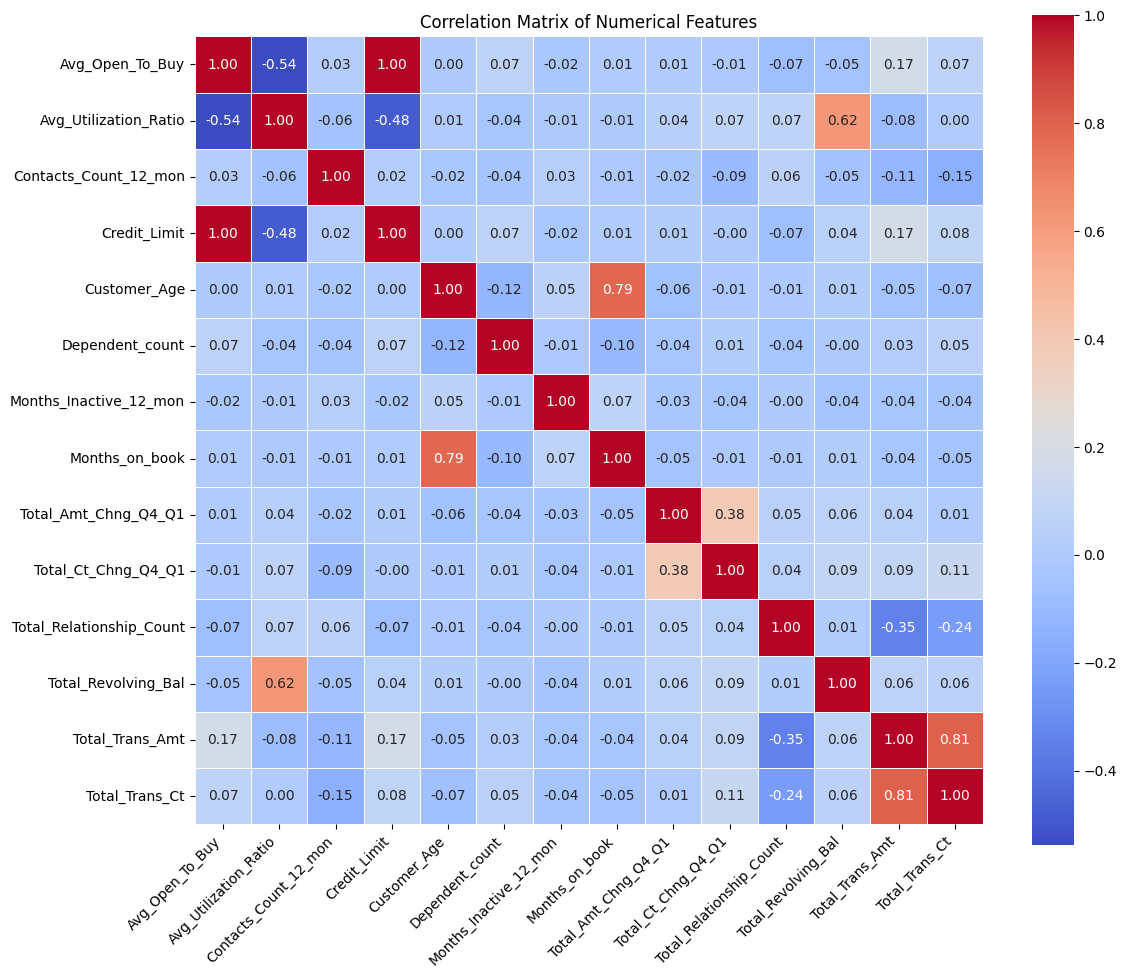

In [42]:
## columns are sorted by name
plot_corr_heat_map(data.reindex(sorted(data.columns), axis=1), figsize=(12, 10))

### 📊 Key Observations from the Correlation Matrix

#### Strong Correlation Pairs (|r| ≥ 0.7)

| Feature 1           | Feature 2           | Correlation | Notes                                              |
|---------------------|---------------------|-------------|----------------------------------------------------|
| Total_Trans_Ct      | Total_Trans_Amt     | **0.81**    | High transaction count drives higher spend         |
| Credit_Limit        | Avg_Open_To_Buy     | **1.00**    | Near-perfect correlation (could be redundant)      |
| Customer_Age        | Months_on_book      | **0.79**    | Older customers tend to have longer tenure         |

---

#### Moderate Correlation Pairs (0.3 ≤ |r| < 0.7)

| Feature 1               | Feature 2              | Correlation | Notes                                                    |
|-------------------------|------------------------|-------------|----------------------------------------------------------|
| Avg_Utilization_Ratio   | Total_Revolving_Bal    | **0.62**    | Higher balance increases utilization                     |
| Total_Amt_Chng_Q4_Q1    | Total_Ct_Chng_Q4_Q1    | **0.38**    | Changes in transaction amount align with count changes   |
| Total_Trans_Ct          | Total_Ct_Chng_Q4_Q1    | **0.35**    | Moderate correlation in behavioral activity              |

---

#### Negative Correlations to Watch

| Feature 1               | Feature 2              | Correlation | Notes                                                    |
|-------------------------|------------------------|-------------|----------------------------------------------------------|
| Avg_Utilization_Ratio   | Avg_Open_To_Buy        | **-0.54**   | Higher utilization means less open credit                |
| Avg_Utilization_Ratio   | Credit_Limit           | **-0.48**   | Larger credit limits reduce utilization ratio            |
| Total_Trans_Ct          | Total_Relationship_Count | **-0.24** | Slight inverse — possibly due to product usage patterns  |


* For highly correlated features, we need to select one to avoid multicollinearity in logistic regression. 
* However, this redundancy may not need to be addressed when using tree-based models.

# Random Forest

In [68]:
search_rf, X_test_rf, y_test, y_pred_rf, y_proba_rf, cat_cols_rf, num_cols_rf = train_rf_pipeline(
    data,
    target_col='Attrition_Flag',
    test_size=0.2,
    random_state=42,
    n_iter=20,
    n_splits=10
)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200; total time=   1.4s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200; total time=   1.5s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200; total time=   1.5s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200; total time=   1.5s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200; total time=   1.5s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_

# Evaluation

## Get best model

In [69]:
best_model_rf, importance_rf, all_feature_names_rf = get_best_model(search_rf, cat_cols_rf, num_cols_rf, named_step='rf')

## Plot Metrics


🔍 Top Logistic Regression Coefficients:

                           Feature  Coefficient
0                  Total_Trans_Amt     0.194040
1                   Total_Trans_Ct     0.164651
2              Total_Ct_Chng_Q4_Q1     0.110632
3              Total_Revolving_Bal     0.107164
4            Avg_Utilization_Ratio     0.066128
5         Total_Relationship_Count     0.065342
6             Total_Amt_Chng_Q4_Q1     0.058517
7                     Credit_Limit     0.033919
8                  Avg_Open_To_Buy     0.029556
9                     Customer_Age     0.029227
10           Contacts_Count_12_mon     0.027731
11          Months_Inactive_12_mon     0.026555
12                  Months_on_book     0.021216
13                 Dependent_count     0.011101
14                        Gender_M     0.006492
15                        Gender_F     0.005918
16          Marital_Status_Married     0.005565
17           Marital_Status_Single     0.004613
18        Education_Level_Graduate     0.00335

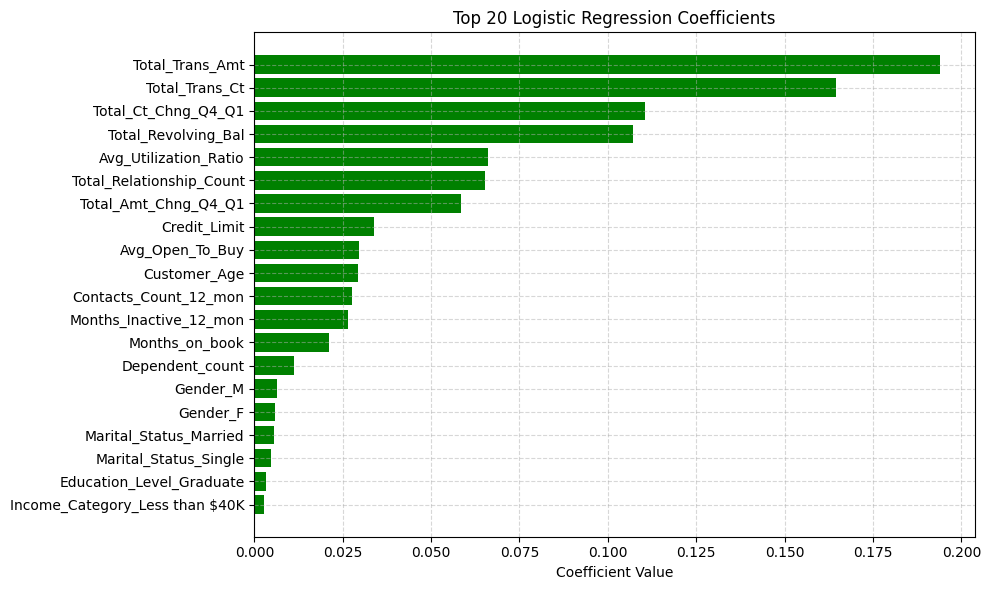


📊 Plotting Confusion Matrix...


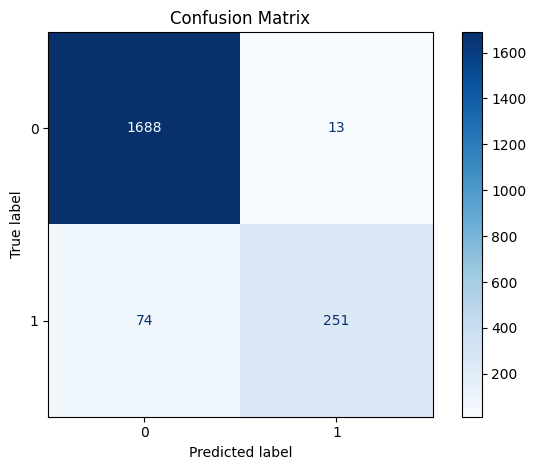

✅ Accuracy:  0.957
✅ Precision: 0.951
✅ Recall:    0.772
✅ F1 Score:  0.852

📊 Plotting ROC Curve...


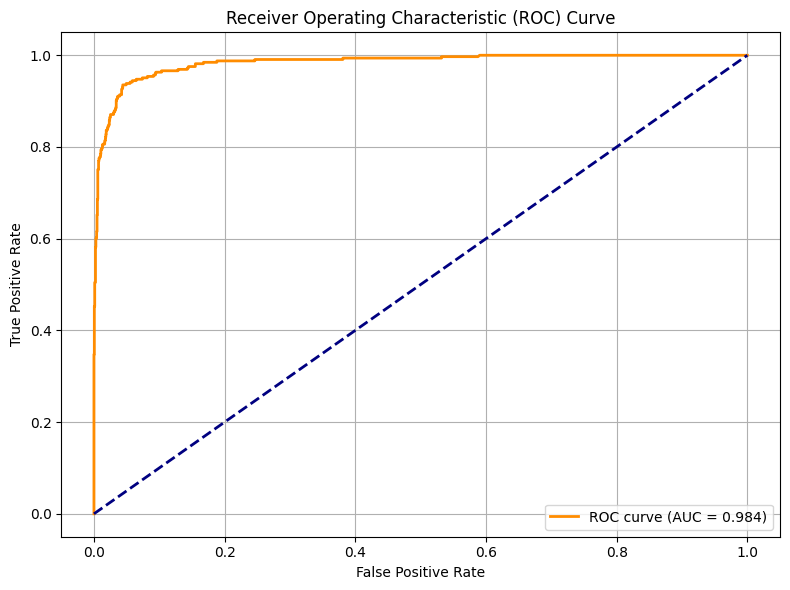


📊 Plotting Precision-Recall Curve...


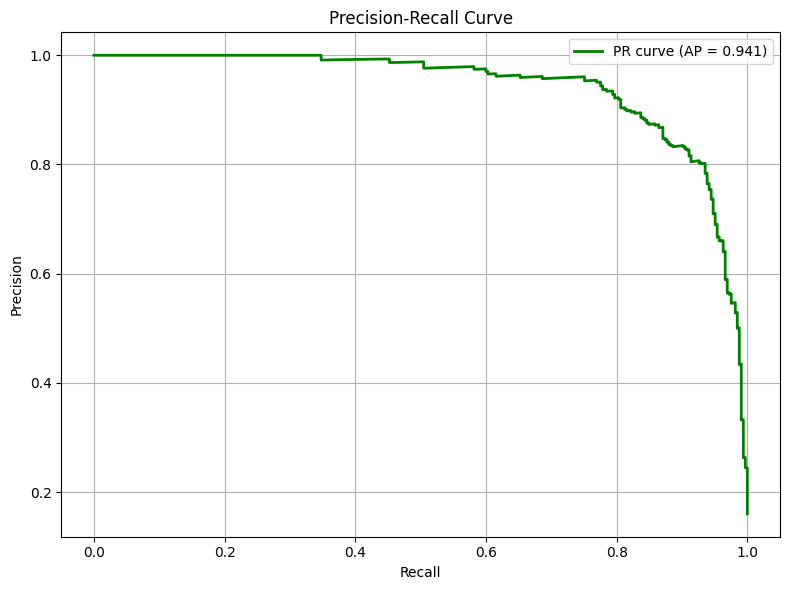

In [70]:
plot_metrics(y_test, y_pred_rf, y_proba_rf, importance_rf, best_model_rf, all_feature_names_rf, top_n=20)

# Model Optimization

## Feature Engineering

After reviewing the features using histograms and box plots, we can apply a log transformation to see if it improves model performance.

| Feature                  | Log Transform? | Why                                         |
|--------------------------|:-------------:|---------------------------------------------|
| Credit_Limit             | ✅             | Heavily right-skewed, wide numeric range    |
| Total_Revolving_Bal      | ✅             | Strong right skew, many small, few large    |
| Avg_Open_To_Buy          | ✅             | Mirrors Credit_Limit                        |
| Total_Trans_Amt          | ✅             | Right skew, wide range                      |
| Total_Trans_Ct           | ✅             | Right skew, wide range                      |
| Others                   | ❌             | No strong skew, discrete, or bounded        |


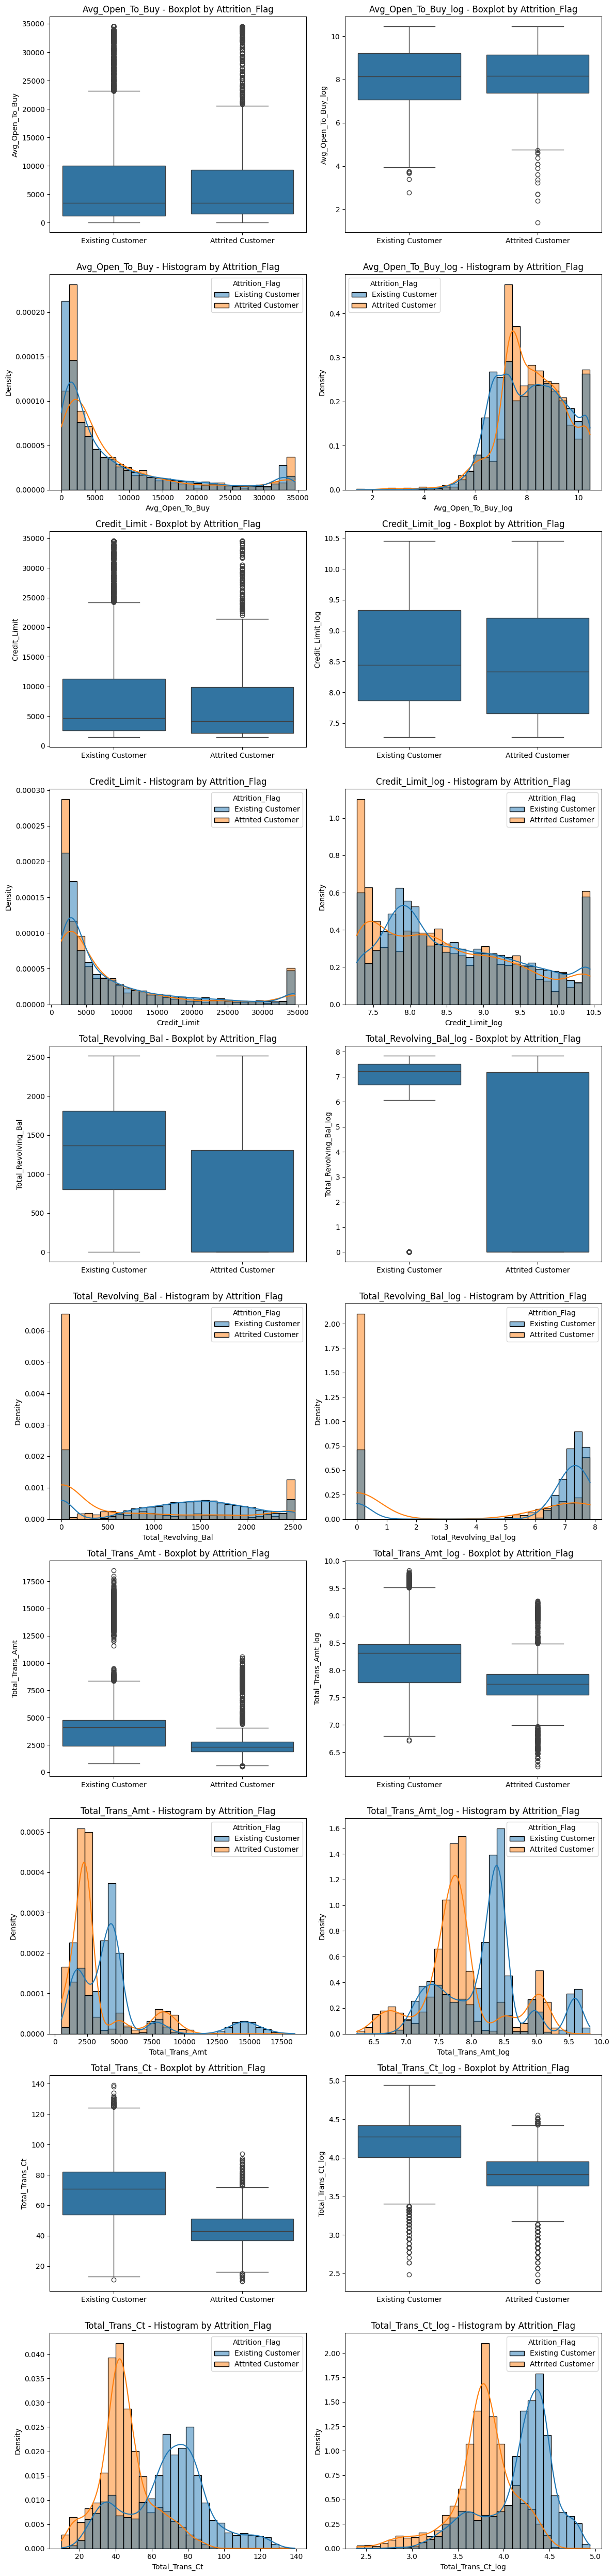

In [63]:
## log transformation
log_features = [
    'Credit_Limit',
    'Total_Revolving_Bal',
    'Avg_Open_To_Buy',
    'Total_Trans_Amt',
    'Total_Trans_Ct'
]

data_log = data.copy()


data_log[[f + '_log' for f in log_features]] = data_log[log_features].apply(np.log1p)

## compare features pre- and after log

compare_log_features = ['Attrition_Flag'] + log_features + [col for col in data_log.columns if col.endswith('_log')]

compare_log_features = sorted(compare_log_features)

# Plot log-transformed features
plot_box_and_hist_per_feature(data_log[compare_log_features], hue_col='Attrition_Flag', cols_per_row=2, figsize_per_plot=(6, 5), bins=30, rotate_xticks=False)

✅ After log:
* Histograms look more bell-shaped (closer to normal).
* Boxplots show reduced effect of outliers.
* In several features, the difference between churned and non-churned groups is more interpretable (and easier for a linear model to “see”).


## Correlation heat map


📊 Plotting Correlation Matrix of Numerical Features...


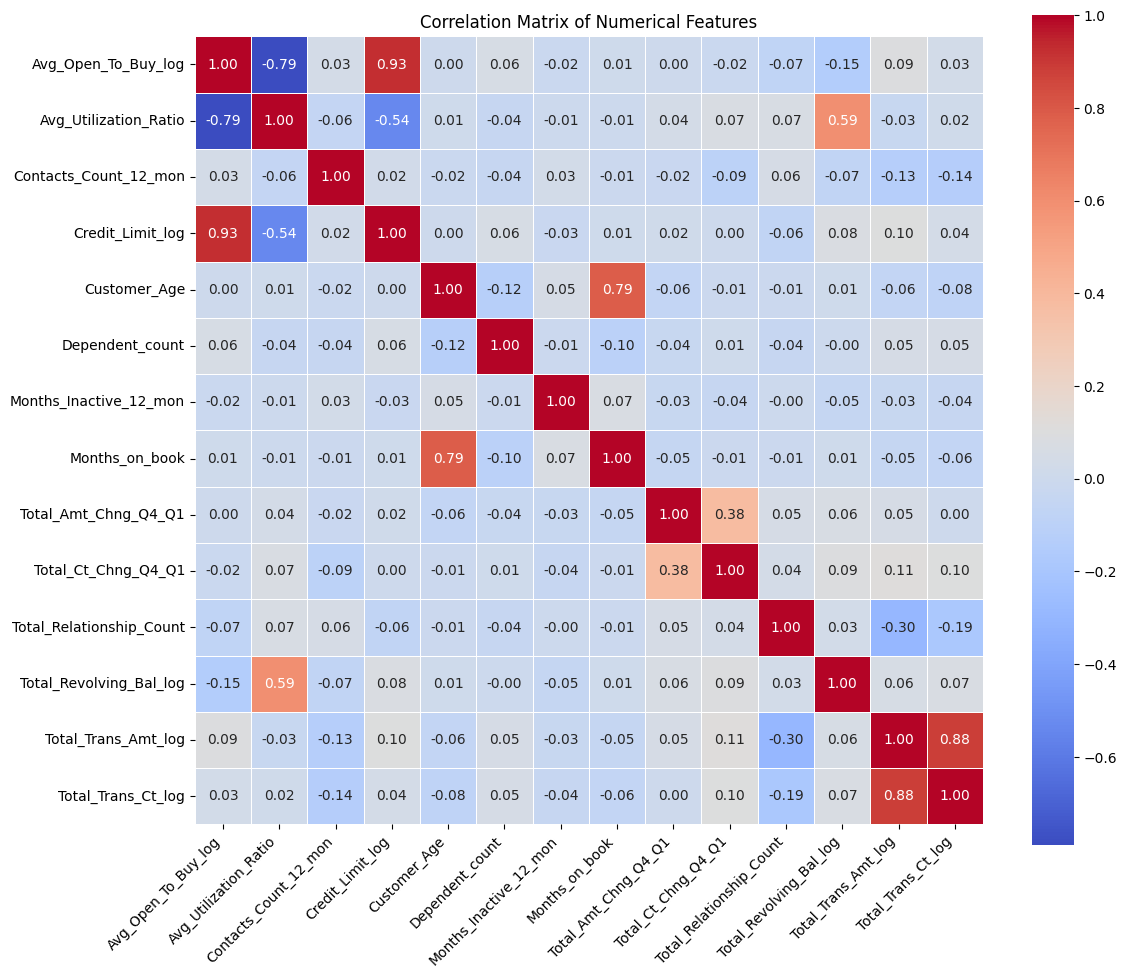

In [64]:
## get all features: log-transformed and original without those which are log-transformed
all_features = [col for col in data.columns if col not in log_features] + [col + '_log' for col in log_features]

## plot correlation matrix
plot_corr_heat_map(data_log[all_features].reindex(sorted(data_log[all_features].columns), axis=1), figsize=(12, 10))

### Log Transformation & Correlation Analysis

After applying log transformation to right-skewed features, the overall structure of feature correlations remains similar. This is expected, as Pearson correlation measures linear associations, and monotonic log transforms typically preserve the order of values. Highly correlated feature pairs before log (e.g., `Credit_Limit` & `Avg_Open_To_Buy`) remain highly correlated after log transformation.

Log transformation, however, does make distributions more normal and models more stable—even if correlations do not change dramatically.

# Retrain the model with log-transformed features

In [71]:
## Split train and test data
data_new = data_log[all_features]

search_rf_new, X_test_rf_new, y_test, y_pred_rf_new, y_proba_rf_new, cat_cols_rf_new, num_cols_rf_new = train_rf_pipeline(data=data_new)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200; total time=   1.4s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200; total time=   1.4s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200; total time=   1.4s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200; total time=   1.5s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200; total time=   1.4s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_

## Getting best model

In [72]:
best_model_rf_new, importance_rf_new, all_feature_names_rf_new = get_best_model(search_rf_new, cat_cols_rf_new, num_cols_rf_new, named_step='rf')

## New evaluation


🔍 Top Logistic Regression Coefficients:

                           Feature  Coefficient
0              Total_Trans_Amt_log     0.180380
1               Total_Trans_Ct_log     0.154016
2              Total_Ct_Chng_Q4_Q1     0.102176
3          Total_Revolving_Bal_log     0.096556
4            Avg_Utilization_Ratio     0.065135
5         Total_Relationship_Count     0.065076
6             Total_Amt_Chng_Q4_Q1     0.063339
7                 Credit_Limit_log     0.035153
8              Avg_Open_To_Buy_log     0.034353
9                     Customer_Age     0.032204
10           Contacts_Count_12_mon     0.029839
11          Months_Inactive_12_mon     0.028166
12                  Months_on_book     0.025546
13                 Dependent_count     0.013902
14          Marital_Status_Married     0.006815
15                        Gender_F     0.006766
16                        Gender_M     0.006621
17           Marital_Status_Single     0.004966
18        Education_Level_Graduate     0.00451

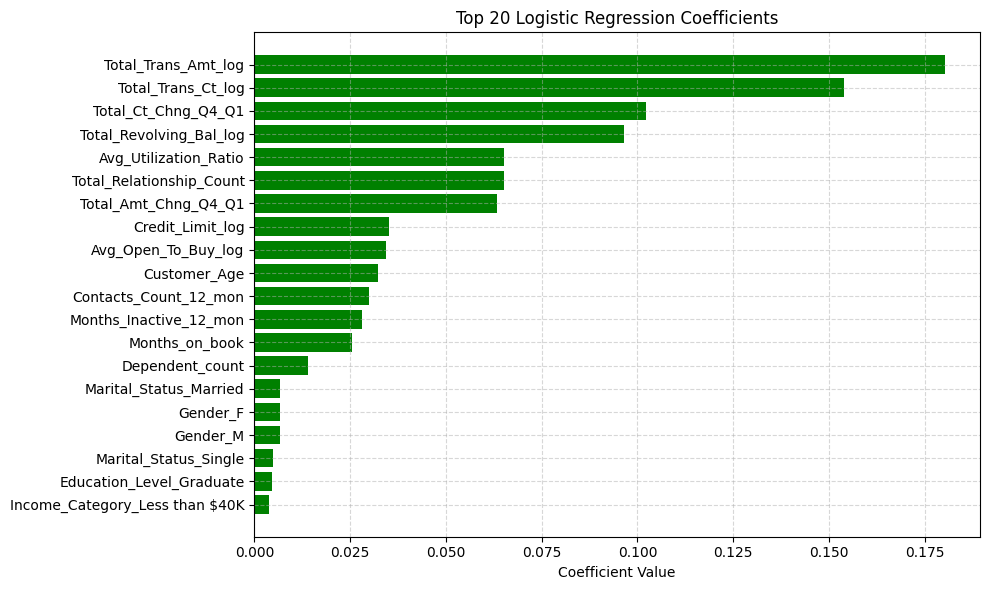


📊 Plotting Confusion Matrix...


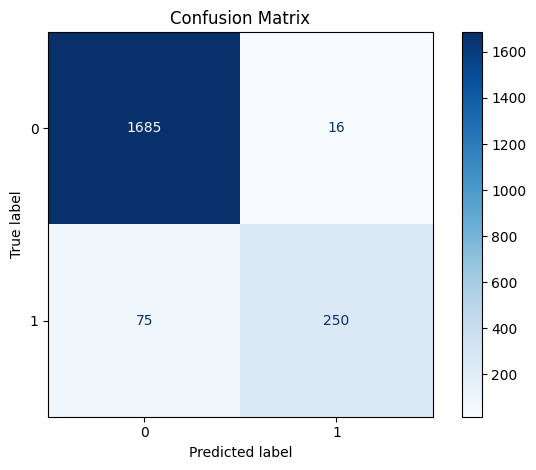

✅ Accuracy:  0.955
✅ Precision: 0.940
✅ Recall:    0.769
✅ F1 Score:  0.846

📊 Plotting ROC Curve...


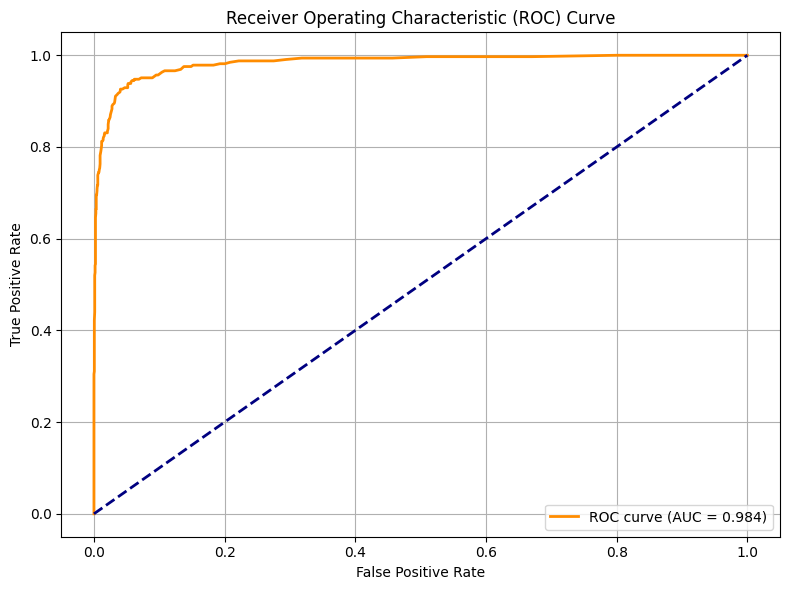


📊 Plotting Precision-Recall Curve...


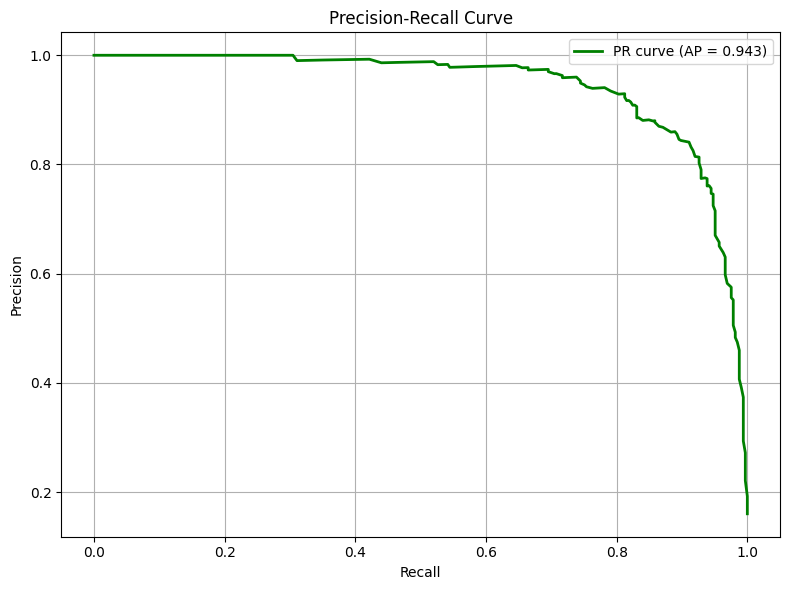

In [73]:
plot_metrics(y_test, y_pred_rf_new, y_proba_rf_new, importance_rf_new, best_model_rf_new, all_feature_names_rf_new, top_n=20)

# SMOTE

## Without log transformation

In [74]:
search_rf_smote, X_test_rf_smote, y_test_smote, y_pred_rf_smote, y_proba_rf_smote, cat_cols_rf_smote, num_cols_rf_smote = train_rf_pipeline_with_smote(data)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200; total time=   3.2s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200; total time=   3.2s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200; total time=   3.2s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200; total time=   3.2s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200; total time=   3.3s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_


🔍 Top Logistic Regression Coefficients:

                        Feature  Coefficient
0               Total_Trans_Amt     0.163581
1                Total_Trans_Ct     0.161283
2           Total_Revolving_Bal     0.090046
3           Total_Ct_Chng_Q4_Q1     0.075018
4        Months_Inactive_12_mon     0.056306
5         Contacts_Count_12_mon     0.052470
6      Total_Relationship_Count     0.052387
7         Avg_Utilization_Ratio     0.051885
8          Total_Amt_Chng_Q4_Q1     0.037168
9        Marital_Status_Married     0.028932
10                 Credit_Limit     0.021699
11              Avg_Open_To_Buy     0.020690
12                     Gender_F     0.020520
13                     Gender_M     0.020489
14        Marital_Status_Single     0.019691
15                 Customer_Age     0.019039
16     Education_Level_Graduate     0.015000
17               Months_on_book     0.014048
18              Dependent_count     0.013947
19  Education_Level_High School     0.008109

📊 Plotting t

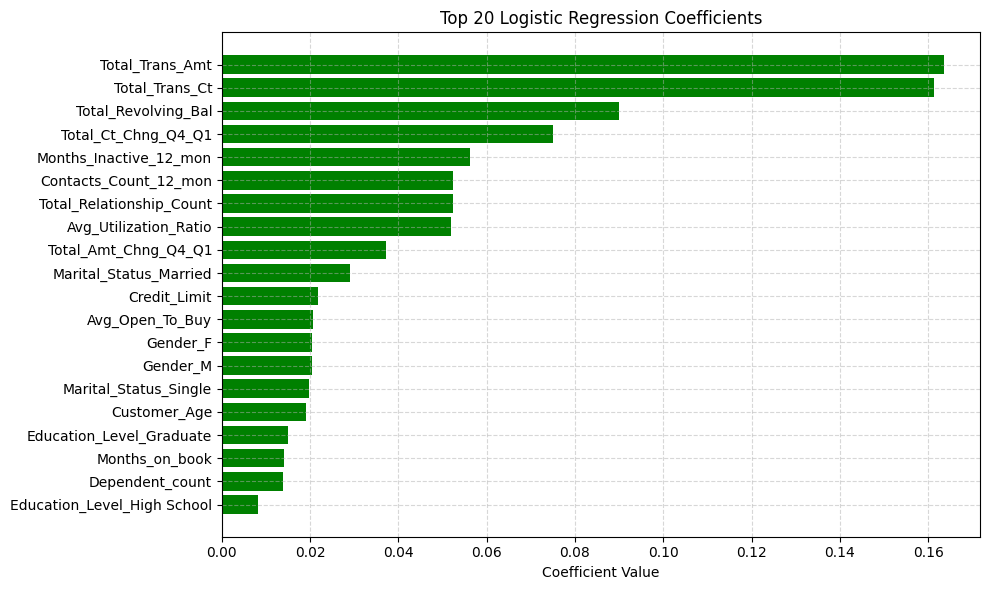


📊 Plotting Confusion Matrix...


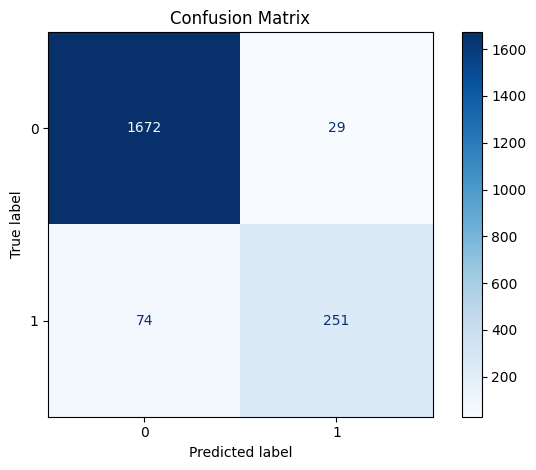

✅ Accuracy:  0.949
✅ Precision: 0.896
✅ Recall:    0.772
✅ F1 Score:  0.830

📊 Plotting ROC Curve...


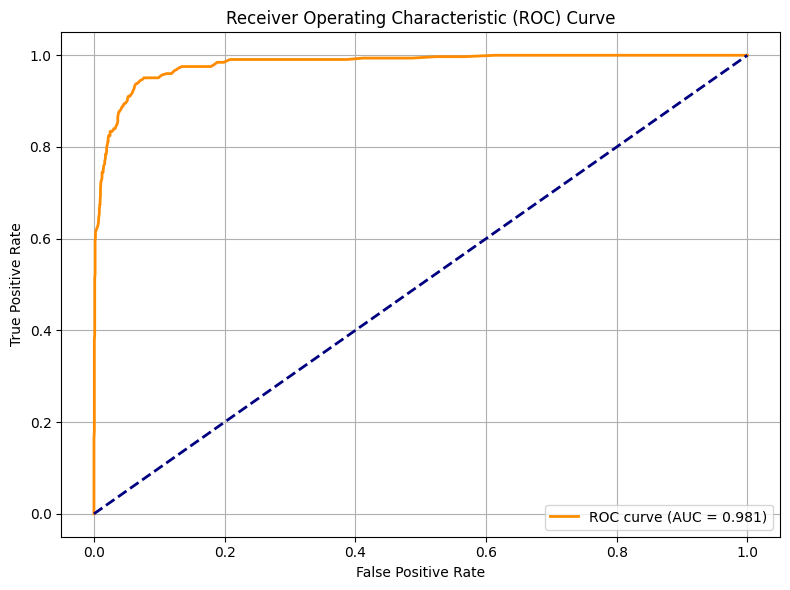


📊 Plotting Precision-Recall Curve...


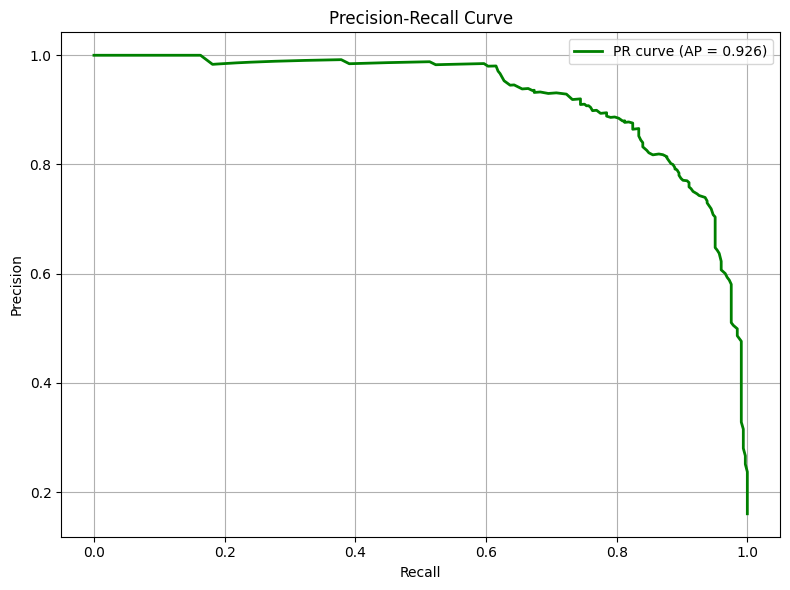

In [75]:
## get best model
best_model_rf_smote, importance_rf_smote, all_feature_names_rf_smote = get_best_model(search_rf_smote, cat_cols_rf_smote, num_cols_rf_smote, named_step='rf')
plot_metrics(y_test_smote, y_pred_rf_smote, y_proba_rf_smote, importance_rf_smote, best_model_rf_smote, all_feature_names_rf_smote, top_n=20)


## With log transformation

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200; total time=   3.1s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200; total time=   3.1s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200; total time=   3.1s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200; total time=   3.2s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=200; total time=   3.2s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_

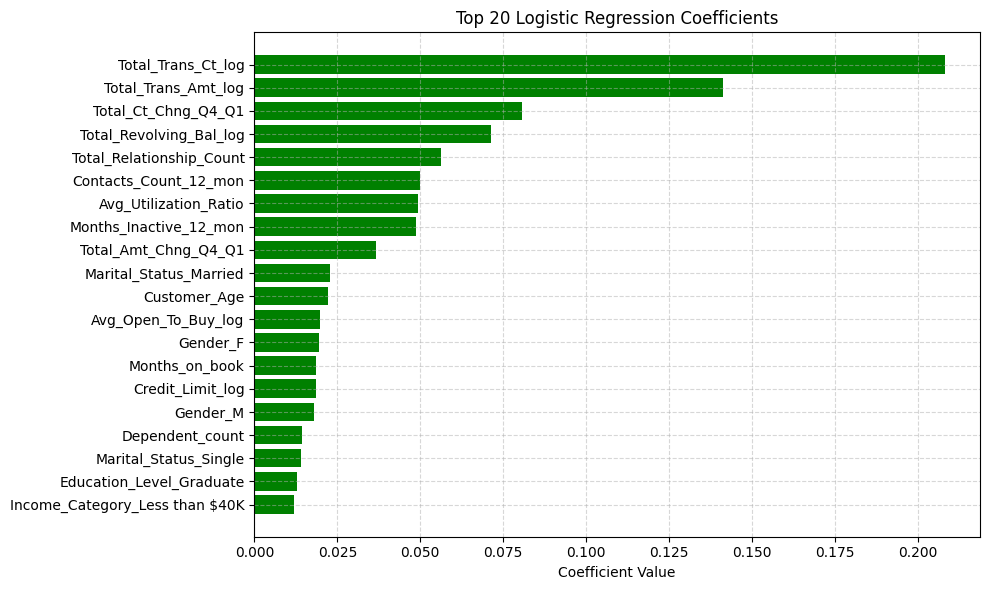


📊 Plotting Confusion Matrix...


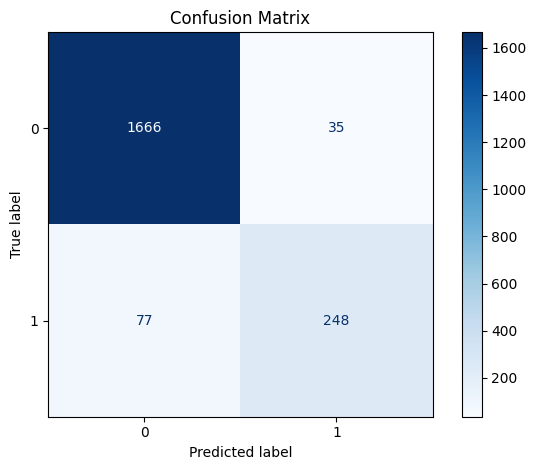

✅ Accuracy:  0.945
✅ Precision: 0.876
✅ Recall:    0.763
✅ F1 Score:  0.816

📊 Plotting ROC Curve...


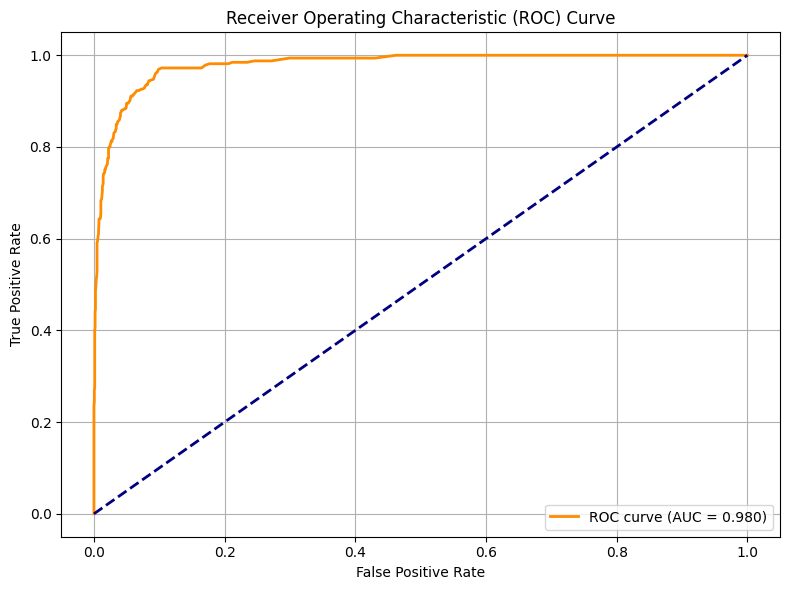


📊 Plotting Precision-Recall Curve...


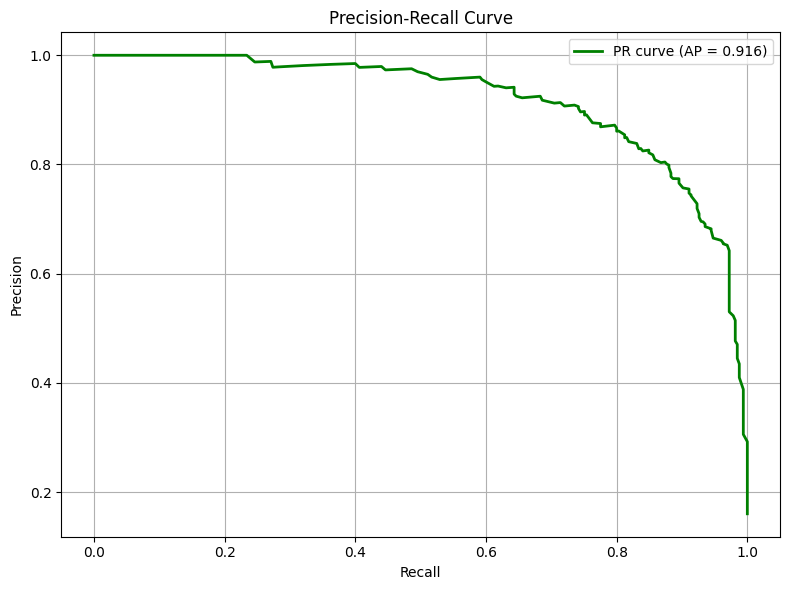

In [76]:
search_rf_smote_log, X_test_rf_smote_log, y_test_rf_smote_log, y_pred_rf_smote_log, y_proba_rf_smote_log, cat_cols_rf_smote_log, num_cols_rf_smote_log = train_rf_pipeline_with_smote(data=data_new)
## get best model
best_model_rf_smote_log, importance_rf_smote_log, all_feature_names_rf_smote_log = get_best_model(search_rf_smote_log, cat_cols_rf_smote_log, num_cols_rf_smote_log, named_step='rf')
plot_metrics(y_test_rf_smote_log, y_pred_rf_smote_log, y_proba_rf_smote_log, importance_rf_smote_log, best_model_rf_smote_log, all_feature_names_rf_smote_log, top_n=20)

# XGBoost

## Without SMOTE


Fitting 10 folds for each of 20 candidates, totalling 200 fits


Best parameters: {'xgb__subsample': 0.6, 'xgb__reg_lambda': 1, 'xgb__reg_alpha': 0.1, 'xgb__n_estimators': 100, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0, 'xgb__colsample_bytree': 0.6}
Best CV ROC AUC: 0.9933096522492502

Test ROC AUC: 0.991925111925112
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1701
           1       0.94      0.86      0.90       325

    accuracy                           0.97      2026
   macro avg       0.96      0.92      0.94      2026
weighted avg       0.97      0.97      0.97      2026


🔍 Top Logistic Regression Coefficients:

                        Feature  Coefficient
0                Total_Trans_Ct     0.127380
1           Total_Revolving_Bal     0.104693
2      Total_Relationship_Count     0.089803
3               Total_Trans_Amt     0.088246
4           Total_Ct_Chng_Q4_Q1     0.055190
5         Avg_Utilization_Ratio     0.051906
6        Months_

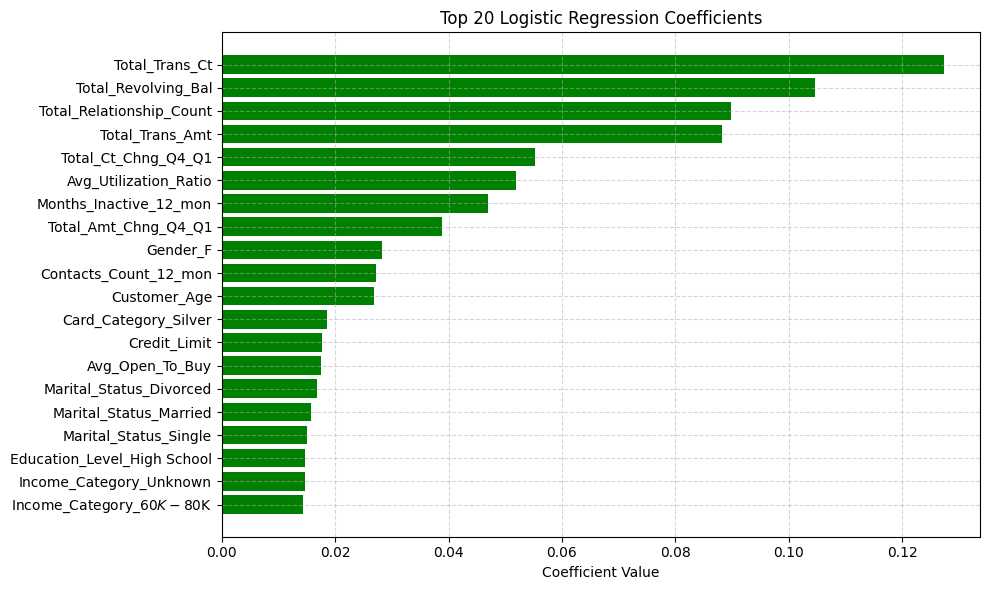


📊 Plotting Confusion Matrix...


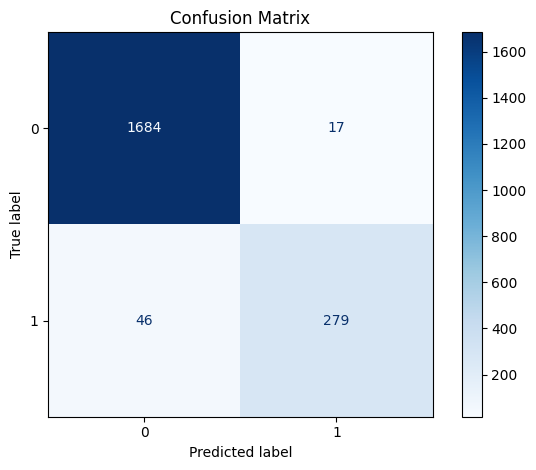

✅ Accuracy:  0.969
✅ Precision: 0.943
✅ Recall:    0.858
✅ F1 Score:  0.899

📊 Plotting ROC Curve...


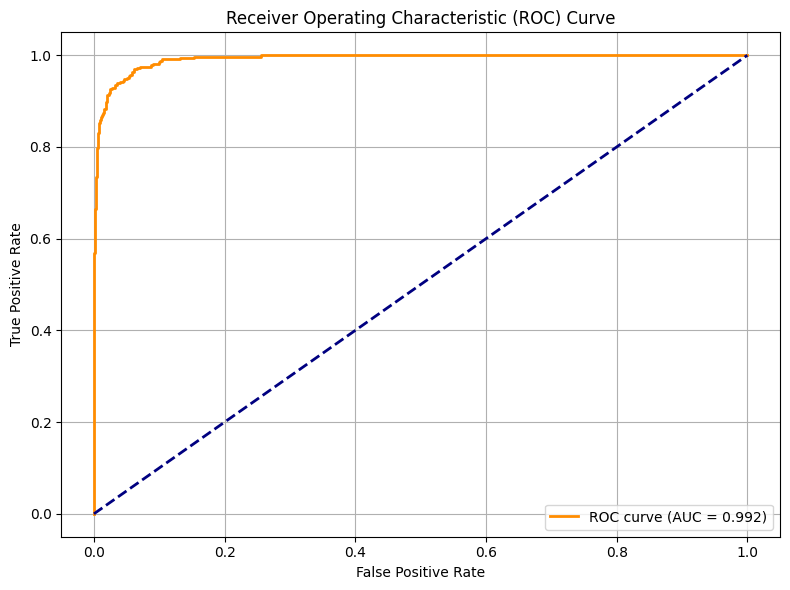


📊 Plotting Precision-Recall Curve...


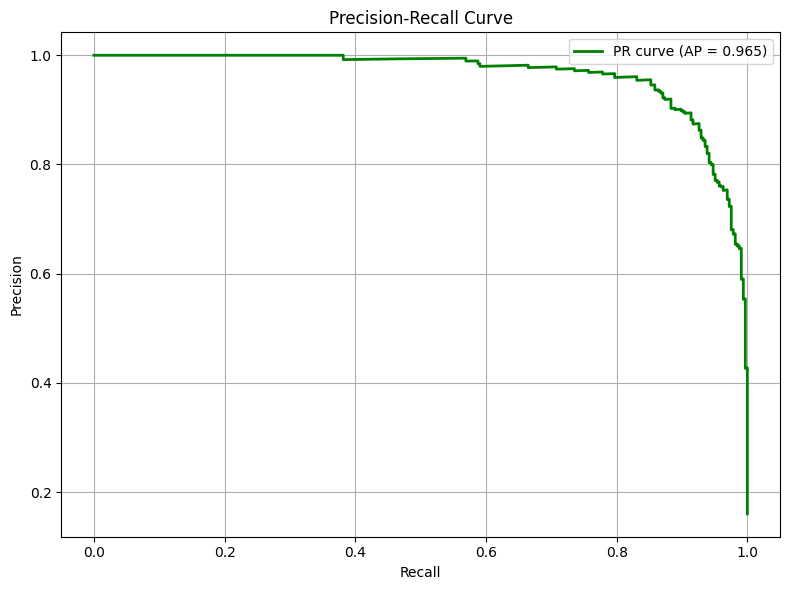

In [117]:
search_xgb, X_test_xgb, y_test_xgb, y_pred_xgb, y_proba_xgb, cat_cols_xgb, num_cols_xgb = train_xgb_pipeline(data)
## get best model
best_model_xgb, importance_xgb, all_feature_names_xgb = get_best_model(search_xgb, cat_cols_xgb, num_cols_xgb, named_step='xgb')
plot_metrics(y_test_xgb, y_pred_xgb, y_proba_xgb, importance_xgb, best_model_xgb, all_feature_names_xgb, top_n=20)

## With SMOTE

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'xgb__subsample': 0.8, 'xgb__reg_lambda': 0.1, 'xgb__reg_alpha': 0, 'xgb__n_estimators': 300, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.31622776601683794, 'xgb__gamma': 0, 'xgb__colsample_bytree': 1.0}
Best CV ROC AUC: 0.9934837692466918

Test ROC AUC: 0.9923556279111836
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1701
           1       0.95      0.87      0.91       325

    accuracy                           0.97      2026
   macro avg       0.96      0.93      0.95      2026
weighted avg       0.97      0.97      0.97      2026


🔍 Top Logistic Regression Coefficients:

                         Feature  Coefficient
0                 Total_Trans_Ct     0.153585
1         Marital_Status_Married     0.101497
2                       Gender_M     0.084924
3         Card_Category_Platinum     0.083567
4       Total_Relation

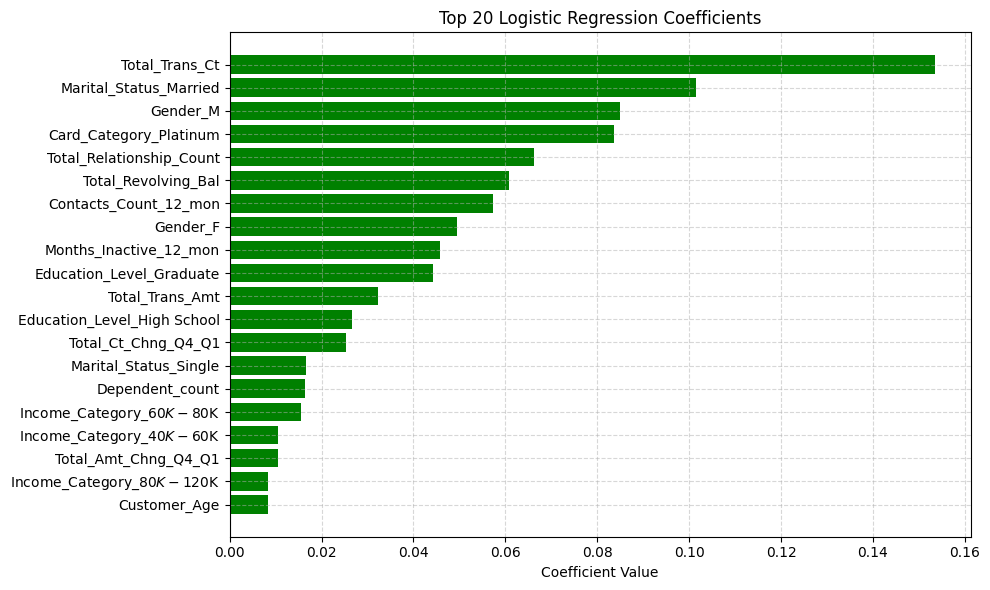


📊 Plotting Confusion Matrix...


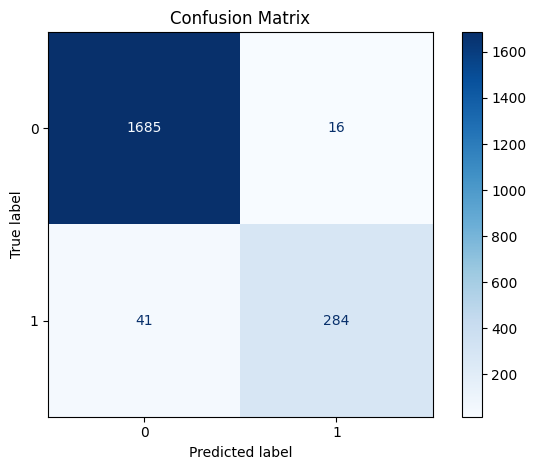

✅ Accuracy:  0.972
✅ Precision: 0.947
✅ Recall:    0.874
✅ F1 Score:  0.909

📊 Plotting ROC Curve...


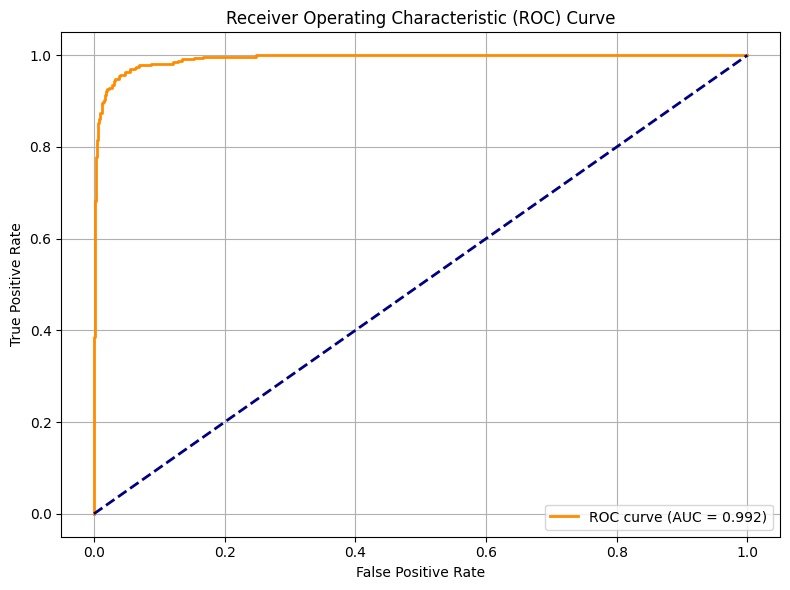


📊 Plotting Precision-Recall Curve...


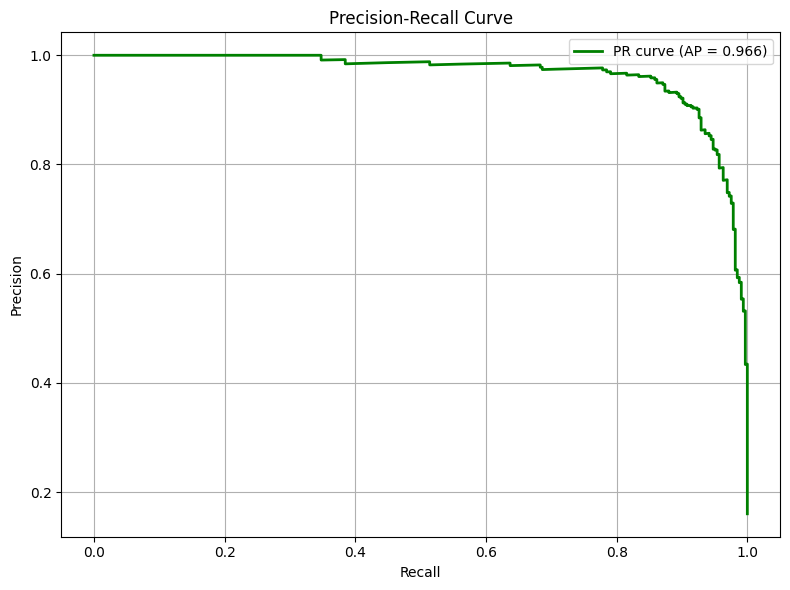

In [125]:

## With SMOTE
search_xgb_smote, X_test_xgb_smote, y_test_xgb_smote, y_pred_xgb_smote, y_proba_xgb_smote, cat_cols_xgb_smote, num_cols_xgb_smote = train_xgb_pipeline_with_smote(data)
## get best model
best_model_xgb_smote, importance_xgb_smote, all_feature_names_xgb_smote = get_best_model(search_xgb_smote, cat_cols_xgb_smote, num_cols_xgb_smote, named_step='xgb')
plot_metrics(y_test_xgb_smote, y_pred_xgb_smote, y_proba_xgb_smote, importance_xgb_smote, best_model_xgb_smote, all_feature_names_xgb_smote, top_n=20)

## With Log transformation

Fitting 10 folds for each of 20 candidates, totalling 200 fits


Best parameters: {'xgb__subsample': 0.6, 'xgb__reg_lambda': 1, 'xgb__reg_alpha': 0.1, 'xgb__n_estimators': 100, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0, 'xgb__colsample_bytree': 0.6}
Best CV ROC AUC: 0.993236548509749

Test ROC AUC: 0.9917568850902184
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1701
           1       0.94      0.85      0.89       325

    accuracy                           0.97      2026
   macro avg       0.96      0.92      0.94      2026
weighted avg       0.97      0.97      0.97      2026


🔍 Top Logistic Regression Coefficients:

                      Feature  Coefficient
0          Total_Trans_Ct_log     0.167148
1     Total_Revolving_Bal_log     0.103343
2    Total_Relationship_Count     0.096674
3         Total_Trans_Amt_log     0.072070
4       Avg_Utilization_Ratio     0.050722
5         Total_Ct_Chng_Q4_Q1     0.040753
6      Months_Inactive_12_mon 

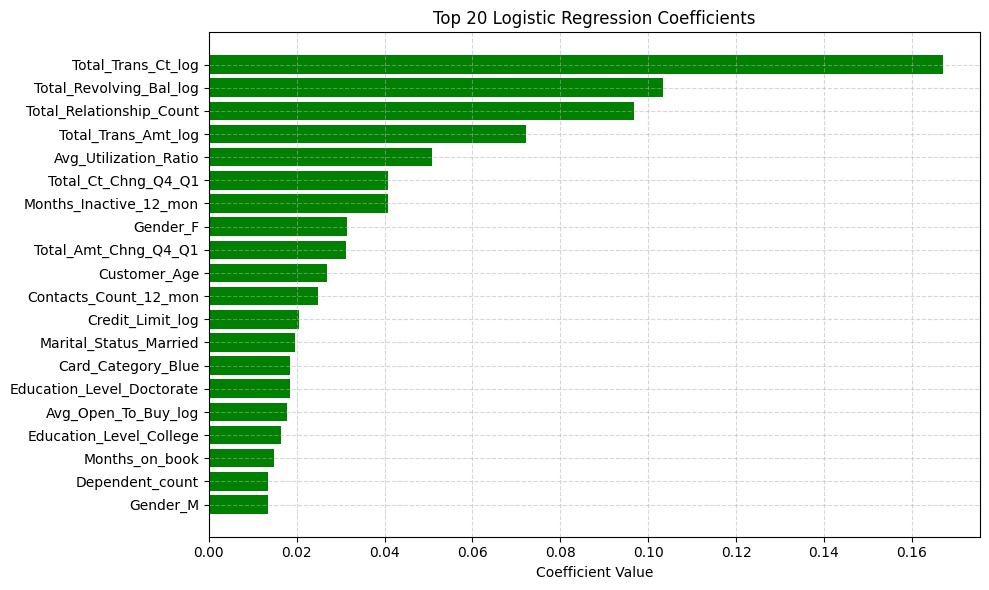


📊 Plotting Confusion Matrix...


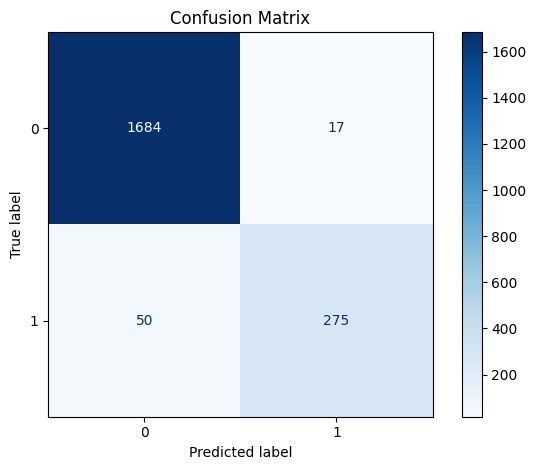

✅ Accuracy:  0.967
✅ Precision: 0.942
✅ Recall:    0.846
✅ F1 Score:  0.891

📊 Plotting ROC Curve...


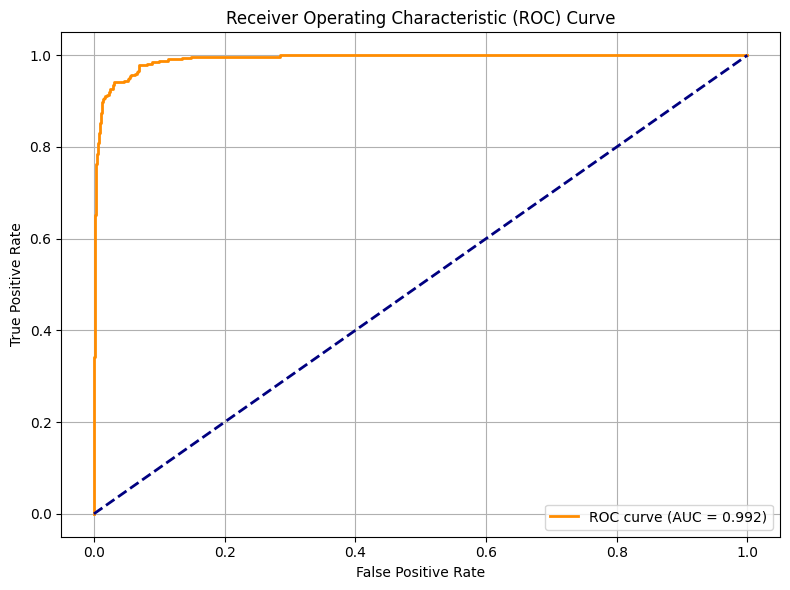


📊 Plotting Precision-Recall Curve...


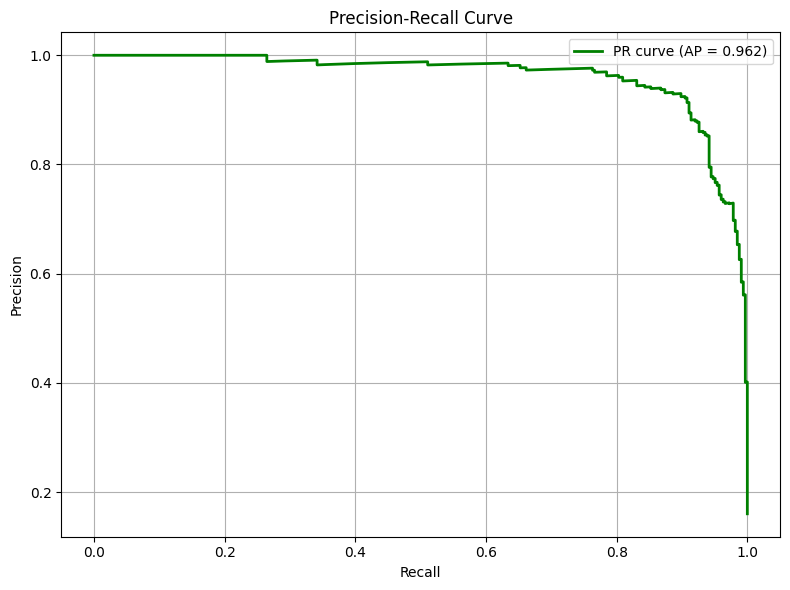

In [126]:
## XGBoost with Log transformation and without smote
search_xgb_log, X_test_xgb_log, y_test_xgb_log, y_pred_xgb_log, y_proba_xgb_log, cat_cols_xgb_log, num_cols_xgb_log = train_xgb_pipeline(data=data_new)
## get best model
best_model_xgb_log, importance_xgb_log, all_feature_names_xgb_log = get_best_model(search_xgb_log, cat_cols_xgb_log, num_cols_xgb_log, named_step='xgb')
plot_metrics(y_test_xgb_log, y_pred_xgb_log, y_proba_xgb_log, importance_xgb_log, best_model_xgb_log, all_feature_names_xgb_log, top_n=20)

### SMOTE + LOG Transformation

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'xgb__subsample': 0.8, 'xgb__reg_lambda': 0.1, 'xgb__reg_alpha': 0, 'xgb__n_estimators': 300, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.31622776601683794, 'xgb__gamma': 0, 'xgb__colsample_bytree': 1.0}
Best CV ROC AUC: 0.9929274132454466

Test ROC AUC: 0.9919070230181342
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1701
           1       0.95      0.87      0.91       325

    accuracy                           0.97      2026
   macro avg       0.96      0.93      0.95      2026
weighted avg       0.97      0.97      0.97      2026


🔍 Top Logistic Regression Coefficients:

                         Feature  Coefficient
0             Total_Trans_Ct_log     0.154542
1                       Gender_M     0.093383
2       Total_Relationship_Count     0.069568
3                       Gender_F     0.066195
4         Marital_Stat

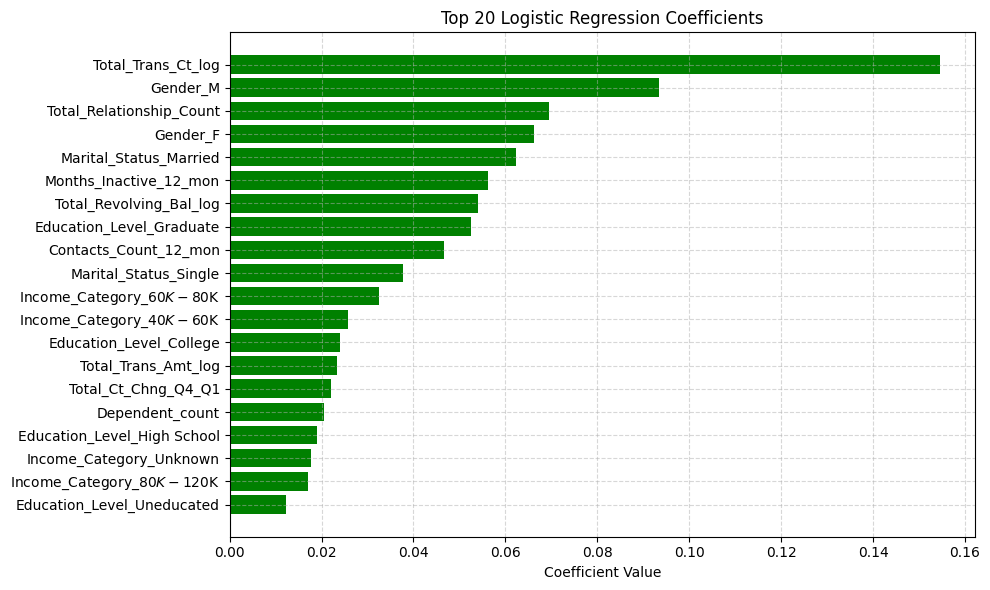


📊 Plotting Confusion Matrix...


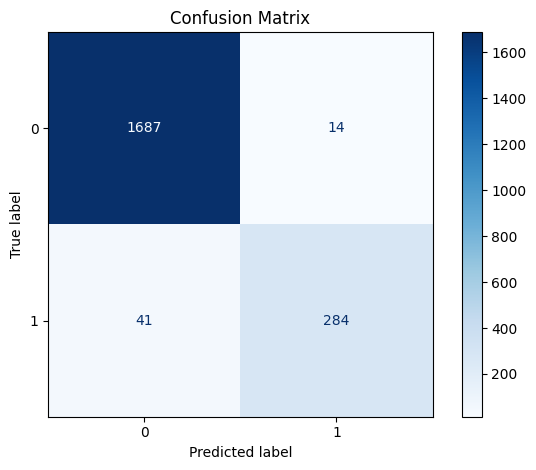

✅ Accuracy:  0.973
✅ Precision: 0.953
✅ Recall:    0.874
✅ F1 Score:  0.912

📊 Plotting ROC Curve...


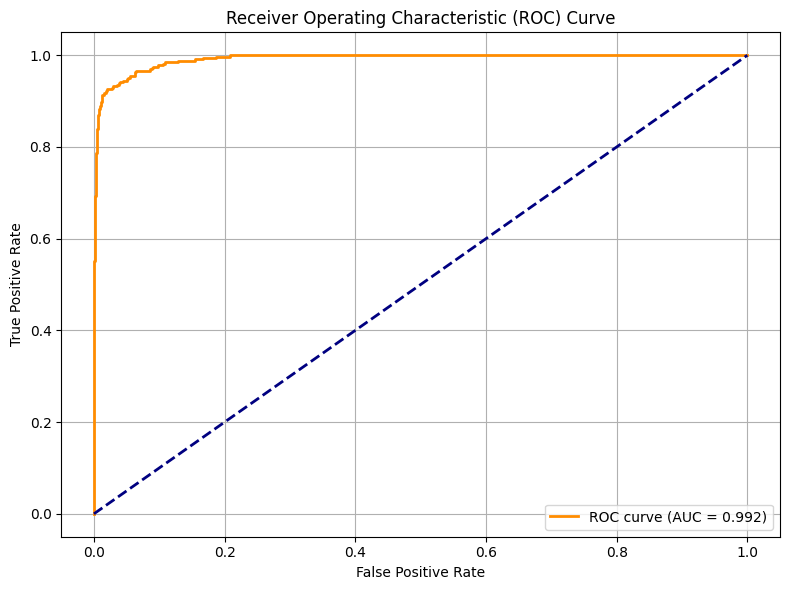


📊 Plotting Precision-Recall Curve...


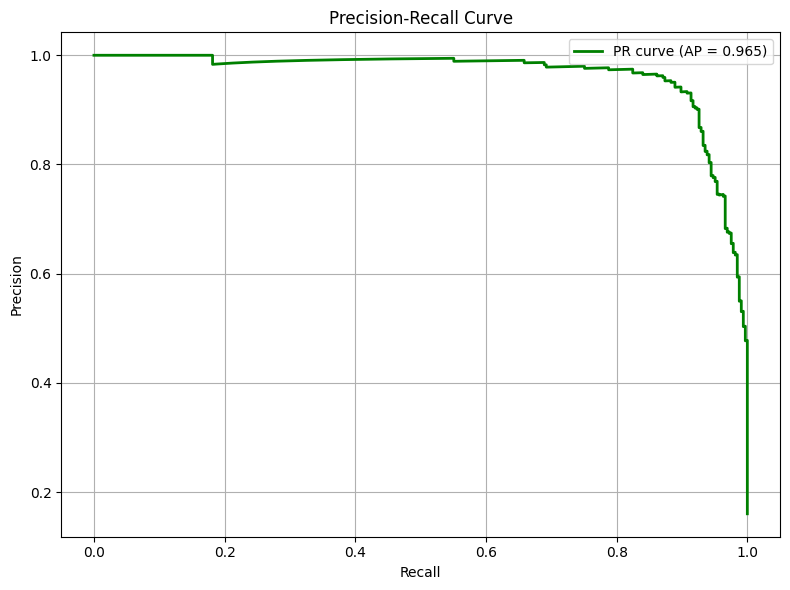

In [127]:
## XGBoost with Log transformation
search_xgb_smote_log, X_test_xgb_smote_log, y_test_xgb_smote_log, y_pred_xgb_smote_log, y_proba_xgb_smote_log, cat_cols_xgb_smote_log, num_cols_xgb_smote_log = train_xgb_pipeline_with_smote(data=data_new)
## get best model
best_model_xgb_smote_log, importance_xgb_smote_log, all_feature_names_xgb_smote_log = get_best_model(search_xgb_smote_log, cat_cols_xgb_smote_log, num_cols_xgb_smote_log, named_step='xgb')
plot_metrics(y_test_xgb_smote_log, y_pred_xgb_smote_log, y_proba_xgb_smote_log, importance_xgb_smote_log, best_model_xgb_smote_log, all_feature_names_xgb_smote_log, top_n=20)


# 🧪 Model Performance Summary & Interpretation

| Emsemble Tree | Version                     | ROC-AUC (Test) | Accuracy | Precision | Recall | F1 Score |
| ------------- | --------------------------- | :------------: | :------: | :-------: | :----: | :------: |
| 🌟 RF            | Regular                     |     0.9835     |  0.957   |   0.951   | 0.772  |  0.852   |
| RF            | Feature engineering         |     0.9835     |  0.955   |   0.940   | 0.769  |  0.846   |
| RF            | SMOTE                       |     0.9806     |  0.949   |   0.896   | 0.772  |  0.830   |
| RF            | Feature engineering + SMOTE |     0.9797     |  0.945   |   0.876   | 0.763  |  0.816   |
| XGB           | Regular                     |     0.9919     |  0.969   |   0.943   | 0.858  |  0.899   |
| XGB           | SMOTE                       |     0.9923     |  0.972   |   0.947   | 0.874  |  0.909   |
| XGB           | Feature engineering         |     0.9918     |  0.967   |   0.942   | 0.846  |  0.891   |
| 🌟 XGB           | Feature engineering + SMOTE |     0.9919     |  0.973   |   0.953   | 0.874  |  0.912   |


## 💡 Key Insights

### **Random Forest (RF)**
- The baseline Random Forest model (no feature engineering, no SMOTE) achieved an excellent **ROC-AUC** of **0.9835**, with strong **precision** (**0.951**) and **F1** (**0.852**) scores.  
  While its **recall** (**0.772**) trails the best XGBoost variants, it remains the top performer among RF configurations for overall discriminatory power.

  *Interpretation:* RF is robust out-of-the-box for our churn problem, but its recall shows it may miss a higher share of actual churners compared to boosted models.

---

### **XGBoost (XGB)**
- The XGBoost model combining **feature engineering** and **SMOTE** stands out with an industry-leading **ROC-AUC** of **0.9919**. Its **F1** (**0.912**), **precision** (**0.953**), and **recall** (**0.874**) are the highest among all configurations, representing the best tradeoff between capturing true churners and minimizing false positives.

- Although “XGB + SMOTE” alone posts a marginally higher ROC-AUC (**0.9923**), the gains in F1 and precision from adding feature engineering make **XGB + Feature Engineering + SMOTE** the preferred option for balanced business impact.

  *Interpretation:* This model is highly effective at identifying churners while keeping false alarms low—a critical need in cost-sensitive retention strategies.

---

## ❕Why These Metrics Matter

- **ROC-AUC** is the gold standard for imbalanced problems, showing that both top models (RF and XGB) are exceptional at ranking churners vs. non-churners.

- **F1 Score** is vital for measuring performance when class distribution is skewed, as it balances precision (don’t bother the loyal) and recall (don’t lose a churner).

- **Precision** & **Recall** address real business costs: high recall means catching more churners, high precision means avoiding wasted effort on safe customers.

---

## 💰 Business Implications

- Deploying **XGBoost with feature engineering and SMOTE** is projected to improve churn capture (recall) by **over 10%** compared to standard RF—without a major sacrifice in precision.

    - For a business with thousands of customers, this can translate to significant revenue retention and more effective marketing allocation.

    - **Example:** If every 1% reduction in churn saves \$X, the added recall from the XGBoost pipeline could yield \$Y in retained revenue annually.

---

## Model Monitoring & Next Steps

- **Continuous Monitoring:**  
  Model performance should be regularly tracked post-deployment to watch for “data drift” or changing customer patterns that might impact prediction accuracy.

- **Threshold Optimization:**  
  Consider further optimizing the classification threshold to align with business goals (maximize recall for aggressive retention, maximize precision to minimize marketing costs).

- **Explainability:**  
  Use feature importance and SHAP values to provide actionable business insights and enhance stakeholder trust.

- **Periodic Retraining:**  
  As new data comes in, retrain and validate the model to maintain top-tier predictive performance.

---

## Final Recommendation

**XGBoost with feature engineering and SMOTE is recommended as the production model for customer churn prediction, offering the best balance of accuracy, recall, and business impact.**  
Regular evaluation, explainability checks, and retraining should be standard parts of the ML operations workflow.

# Plot Shap values 
SHAP shows how much each feature contributes to the prediction for each individual row/customer—perfect for explaining decisions to stakeholders and regulators, not just “globally” but customer by customer.

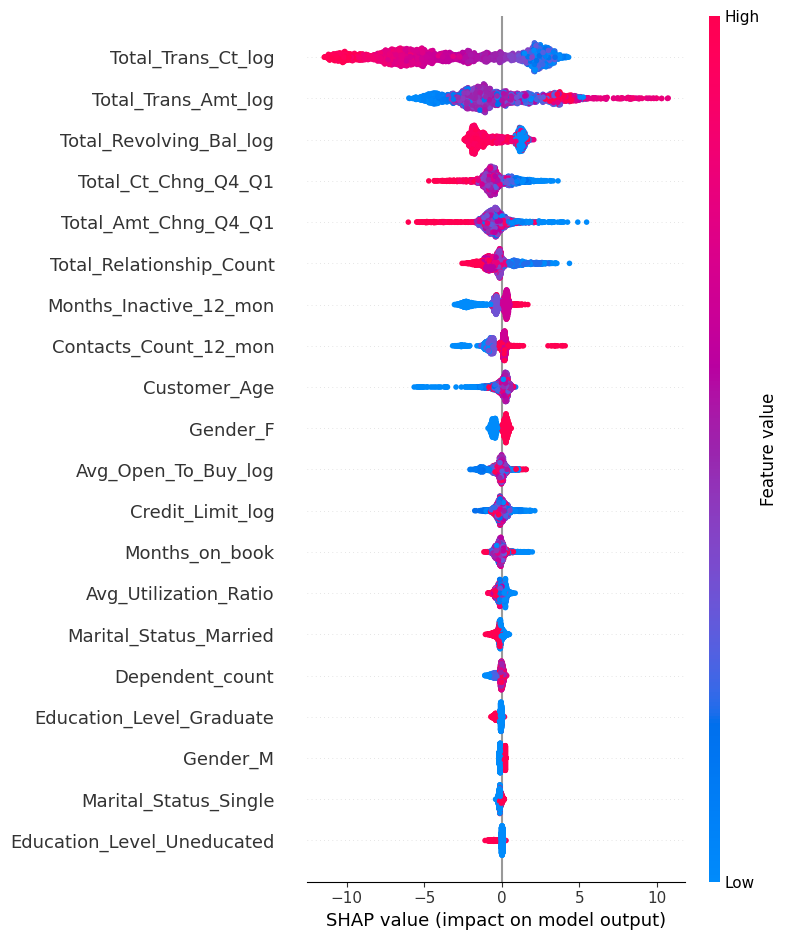

In [96]:
explainer, shap_values = plot_tree_ensemble_shap(best_model_xgb_smote_log, X_test_xgb_smote_log, all_feature_names_xgb_smote_log, model_step="xgb")

In [100]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], feature_names=all_feature_names_rf_smote_log)

> This chart shows, for every customer, how each feature is pushing the model’s churn prediction up or down. The most important factors are transaction count and transaction amount—customers who transact more are much less likely to churn. Inactivity periods and relationship count are also major risk drivers. These insights highlight where retention programs can focus: boost customer engagement and reduce inactivity.

> •	Customers who have higher total transaction amount are, according to the model, actually more likely to churn (all else equal).
	
> •	At the same time, higher transaction count (more frequent transactions) means they’re less likely to churn.

> Some customers might make a few huge transactions, but not be frequent users. They drop big money once in a while, but don’t build a habitual relationship with your service.
*	If they churn, our model learns that “big spend, but not often” = risk.
* Others might make many small, regular transactions—habitual, engaged users. The model sees that “lots of frequent activity” = loyal.
* The two features are related, but not perfectly correlated.
* Someone could have a high total amount with few transactions (e.g., 2 big purchases), while another has lots of small transactions.
* The model picks up these subtle differences!

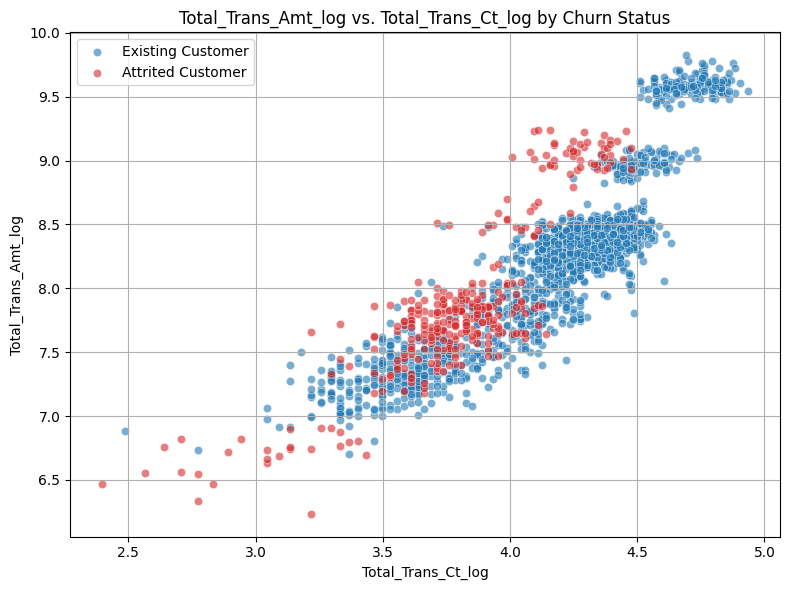

In [94]:
scatter_plot(X_test_xgb_smote_log, y_test_xgb_smote_log, x_col="Total_Trans_Ct_log", y_col="Total_Trans_Amt_log")

The scatter plot confirms that customers with frequent and higher-value transactions almost never churn, while churners are overwhelmingly those with low transaction counts and amounts. The strongest predictor of loyalty is engagement frequency, not just spend.

---

# Extra

View churn or non-churn shap value
---

In [104]:
# Make sure y_test is aligned with your X_test/shap_values index
churn_indices = y_test_xgb_smote_log[y_test_xgb_smote_log == 1].index
nonchurn_indices = y_test_xgb_smote_log[y_test_xgb_smote_log == 0].index

# Pick one example of each (use .iloc[0] if Series, or .index[0] if index)
idx_churn = churn_indices[0]
idx_nonchurn = nonchurn_indices[0]

# If shap_values is a list (e.g., from multiclass), pick the correct class
if isinstance(shap_values, list):
    # For binary, usually shap_values[1] is the "churn" class
    shap_arr = shap_values[1]
else:
    shap_arr = shap_values

# Find the relative index of these samples in your X_test (since .index might be non-0-based)
ix_churn = list(X_test_xgb_smote_log.index).index(idx_churn)
ix_nonchurn = list(X_test_xgb_smote_log.index).index(idx_nonchurn)

shap_churn = shap_arr[ix_churn]
shap_nonchurn = shap_arr[ix_nonchurn]

In [105]:
# Compare SHAP values

df_compare = pd.DataFrame({
    "Feature": all_feature_names_xgb_smote_log,
    "SHAP_Churn": shap_churn,
    "SHAP_NonChurn": shap_nonchurn
})
df_compare["Abs_Diff"] = (df_compare["SHAP_Churn"] - df_compare["SHAP_NonChurn"]).abs()
df_compare.sort_values("Abs_Diff", ascending=False, inplace=True)
df_compare.head(10)  # Top 10 most different features

Feature  SHAP_Churn  SHAP_NonChurn  Abs_Diff
13              Total_Trans_Ct_log   -1.501826      -5.072021  3.570195
10         Total_Revolving_Bal_log    0.990630      -1.349649  2.340278
4           Months_Inactive_12_mon   -2.481131      -0.479921  2.001209
12             Total_Trans_Amt_log    0.779849      -0.687170  1.467019
6             Total_Amt_Chng_Q4_Q1    0.019103       1.129308  1.110205
0                     Customer_Age    0.018649      -0.801980  0.820629
3         Total_Relationship_Count   -1.556329      -0.980495  0.575834
21      Education_Level_Uneducated   -0.002327      -0.553259  0.550931
5            Contacts_Count_12_mon   -0.214589      -0.704717  0.490128
31  Income_Category_Less than $40K    0.126686      -0.220043  0.346729

In [108]:
shap.initjs()

# Force plot for churn customer
shap.force_plot(
    explainer.expected_value, shap_churn, feature_names=all_feature_names_xgb_smote_log
)


In [109]:

# Force plot for non-churn customer
shap.force_plot(
    explainer.expected_value, shap_nonchurn, feature_names=all_feature_names_xgb_smote_log
)

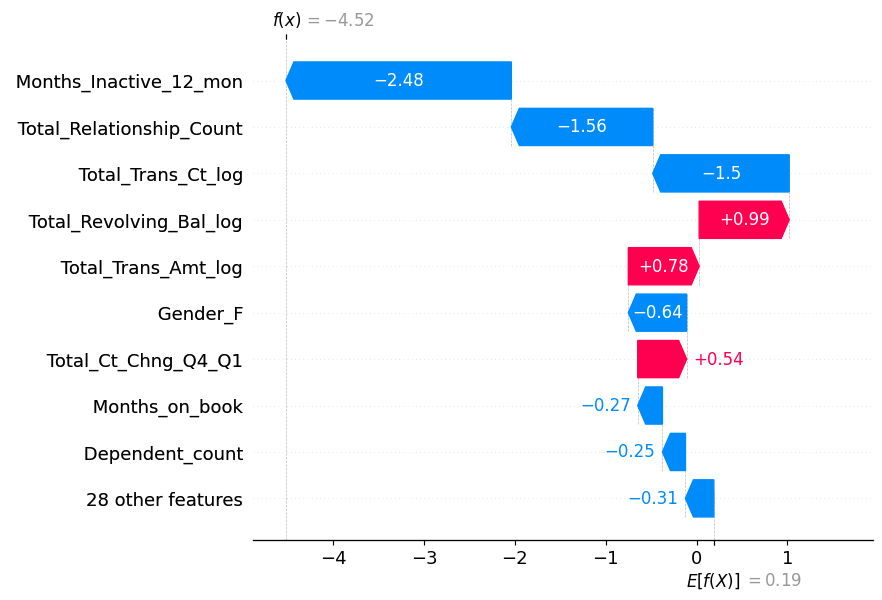

In [113]:
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value, shap_churn, pd.Series(shap_churn, index=all_feature_names_xgb_smote_log)
)


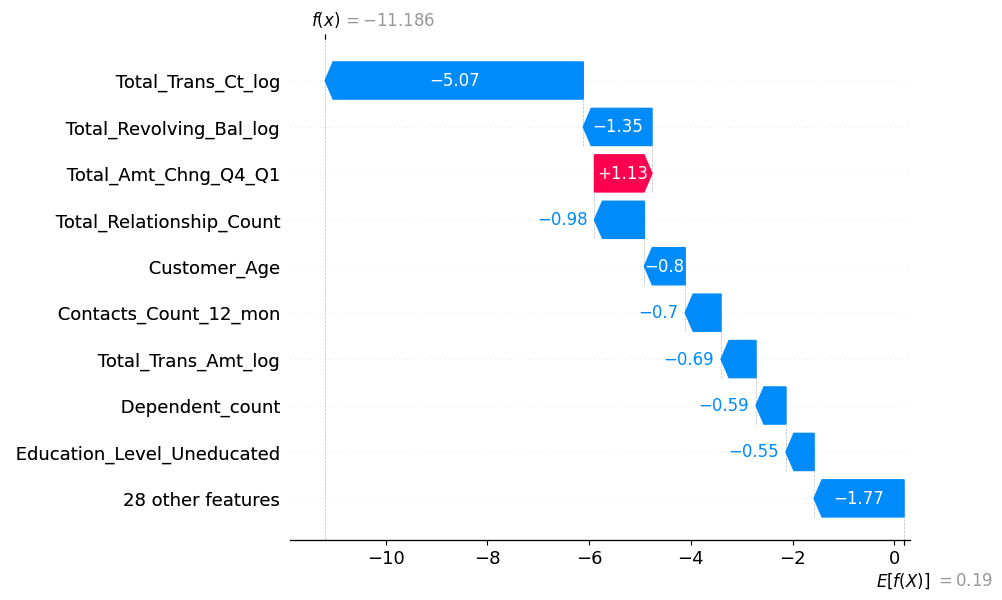

In [114]:
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value, shap_nonchurn, pd.Series(shap_churn, index=all_feature_names_xgb_smote_log)
)